In [ ]:
!pip install fredapi ta arch pytrends
import pandas as pd
from fredapi import Fred
from google.colab import files
import yfinance as yf
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
from sklearn import linear_model
import statsmodels.api as sm
import ta


import warnings
warnings.filterwarnings("ignore", category=Warning)
from pytrends.request import TrendReq

pytrends = TrendReq(hl='en-US', tz=360)

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 15.8 MB/s eta 0:00:00
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=90ccd0e277d6f9ccb960e4bf2dfa6842f6ed76906aead36900dd049754332dae
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [ ]:
meta = yf.download('META', start='2020-01-01', end='2024-12-31')
meta = meta.copy()
meta.dropna(inplace=True)

meta_clean = pd.DataFrame({
    'Open': meta['Open'].squeeze(),
    'High': meta['High'].squeeze(),
    'Low': meta['Low'].squeeze(),
    'Close': meta['Close'].squeeze(),
    'Volume': meta['Volume'].squeeze()
}, index=meta.index)

meta = meta_clean.copy()

meta['SMA_10'] = ta.trend.SMAIndicator(close=meta['Close'], window=10).sma_indicator()
meta['SMA_50'] = ta.trend.SMAIndicator(close=meta['Close'], window=50).sma_indicator()

meta['EMA_10'] = ta.trend.EMAIndicator(close=meta['Close'], window=10).ema_indicator()
meta['EMA_50'] = ta.trend.EMAIndicator(close=meta['Close'], window=50).ema_indicator()

macd = ta.trend.MACD(close=meta['Close'])
meta['MACD'] = macd.macd()
meta['MACD_signal'] = macd.macd_signal()
meta['MACD_diff'] = macd.macd_diff()

meta['RSI_14'] = ta.momentum.RSIIndicator(close=meta['Close'], window=14).rsi()
meta['Stoch_RSI'] = ta.momentum.StochRSIIndicator(close=meta['Close']).stochrsi()
meta['CCI_20'] = ta.trend.CCIIndicator(high=meta['High'], low=meta['Low'], close=meta['Close'], window=20).cci()
meta['ROC'] = ta.momentum.ROCIndicator(close=meta['Close'], window=12).roc()

bb = ta.volatility.BollingerBands(close=meta['Close'], window=20, window_dev=2)
meta['BB_MAVG'] = bb.bollinger_mavg()
meta['BB_HIGH'] = bb.bollinger_hband()
meta['BB_LOW'] = bb.bollinger_lband()
meta['BB_WIDTH'] = bb.bollinger_wband()

meta['ATR_14'] = ta.volatility.AverageTrueRange(high=meta['High'], low=meta['Low'], close=meta['Close'], window=14).average_true_range()

meta['OBV'] = ta.volume.OnBalanceVolumeIndicator(close=meta['Close'], volume=meta['Volume']).on_balance_volume()
meta['CMF_20'] = ta.volume.ChaikinMoneyFlowIndicator(high=meta['High'], low=meta['Low'], close=meta['Close'], volume=meta['Volume'], window=20).chaikin_money_flow()
meta['MFI_14'] = ta.volume.MFIIndicator(high=meta['High'], low=meta['Low'], close=meta['Close'], volume=meta['Volume'], window=14).money_flow_index()

meta = meta.copy()
meta['Date'] = meta.index  # create a new column from index
meta['Date'] = meta['Date'].dt.strftime('%Y-%m-%d')
meta.reset_index(drop=True, inplace=True)  # remove index

cols = ['Date'] + [col for col in meta.columns if col != 'Date']
meta_df = meta[cols]


meta_df.to_csv('meta_TA.csv', index=False)
from google.colab import files
files.download("meta_TA.csv")


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ================================
# 📦 LIBRARY IMPORTS
# ================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler

# ================================
# 📂 LOAD PREVIOUS FEATURE CSV
# ================================
file_path = "meta_TA.csv"
df = pd.read_csv(file_path)

# Convert Date to datetime index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.sort_index()

# ================================
# 📊 BASIC MOVING AVERAGES & RETURNS
# ================================
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()
df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))
df['Next_Day_Return'] = df['Close'].pct_change().shift(-1)

# ================================
# ⏪ LAGGED FEATURES
# ================================
for i in range(1, 6):
    df[f'Lag_{i}_Close'] = df['Close'].shift(i)
    df[f'Lag_{i}_Return'] = df['Log_Return'].shift(i)

# ================================
# 📈 ROLLING STATISTICS
# ================================
df['Rolling_STD_20'] = df['Close'].rolling(20).std()
df['Rolling_Max_20'] = df['Close'].rolling(20).max()
df['Rolling_Min_20'] = df['Close'].rolling(20).min()

# ================================
# 💹 RSI CALCULATION
# ================================
def calculate_rsi(df, period=14):
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0).rolling(period).mean()
    loss = -delta.where(delta < 0, 0).rolling(period).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

calculate_rsi(df)

# ================================
# 🎯 BOLLINGER BANDS + FIXED BB_MAVG, BB_WIDTH
# ================================
df['BB_MAVG'] = df['Close'].rolling(window=20).mean()
rolling_std = df['Close'].rolling(window=20).std()
df['Upper Band'] = df['BB_MAVG'] + 2 * rolling_std
df['Lower Band'] = df['BB_MAVG'] - 2 * rolling_std
df['BB_WIDTH'] = df['Upper Band'] - df['Lower Band']
df['BB_Deviation'] = (df['Close'] - df['BB_MAVG']) / df['BB_WIDTH']

# ================================
# 🏷️ MULTIDAY RETURN LABELS (FOR ML)
# ================================
df['Return_3D'] = df['Close'].pct_change(3).shift(-3)
df['Return_7D'] = df['Close'].pct_change(7).shift(-7)
df['Target_3D'] = (df['Return_3D'] > 0).astype(int)
df['Target_7D'] = (df['Return_7D'] > 0).astype(int)

# ================================
# ✅ COMBINED BUY/SELL SIGNAL SCORE
# ================================
df['Signal_Score'] = 0
df['Signal_Score'] += (df['RSI'] < 30).astype(int)
df['Signal_Score'] += (df['MACD_diff'] > 0).astype(int)
df['Signal_Score'] += (df['Close'] < df['Lower Band']).astype(int)
df['Strong_Buy'] = (df['Signal_Score'] >= 2)

# Buy/Sell signal markers (for later plotting)
df['Buy_Signal'] = (df['RSI'] < 30) & (df['MACD_diff'] > 0)
df['Sell_Signal'] = (df['RSI'] > 70) & (df['MACD_diff'] < 0)

# ================================
# 📊 CATEGORICAL VOLATILITY BUCKETS
# ================================
df['Volatility_Level'] = pd.qcut(df['Rolling_STD_20'], q=3, labels=['Low', 'Medium', 'High'])

# ================================
# 📏 NORMALIZE SELECTED FEATURES
# ================================
features_to_scale = ['SMA_20', 'EMA_20', 'RSI', 'MACD', 'OBV', 'Log_Return', 'Rolling_STD_20']
scaler = StandardScaler()
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

# ================================
# 💾 EXPORT FINAL FEATURE MART
# ================================
df.to_csv("META_FeatureMart_2020_2024.csv", index=True)
print("✅ Feature mart saved as META_FeatureMart_2020_2024.csv")
from google.colab import files
files.download("META_FeatureMart_2020_2024.csv")


✅ Feature mart saved as META_FeatureMart_2020_2024.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 📘 META Stock Feature Mart Dictionary (2020–2024)

---

## 🧾 SECTION 1: Basic OHLCV Data

| Column     | Description                                | Use in Modeling                                 |
|------------|--------------------------------------------|--------------------------------------------------|
| `Open`     | Price at market open                       | Raw input for patterns/volatility                |
| `High`     | Intraday high                              | Range features, candle shapes                   |
| `Low`      | Intraday low                               | Range features, candle shapes                   |
| `Close`    | Price at market close                      | Core signal for most indicators                 |
| `Volume`   | Trading volume                             | Demand/supply pressure, OBV, MFI                |

---

## 📈 SECTION 2: Trend Indicators

| Column         | Description                                      | Use in Modeling                          |
|----------------|--------------------------------------------------|------------------------------------------|
| `SMA_10`/`50`  | Simple Moving Averages (10/50 days)              | Detect trend direction                   |
| `EMA_10`/`50`  | Exponential Moving Averages (10/50 days)         | Faster reaction than SMA                 |
| `MACD`         | Difference of 12- and 26-day EMAs                | Momentum signal                          |
| `MACD_signal`  | 9-day EMA of MACD                                | Smoother confirmation                    |
| `MACD_diff`    | MACD - Signal Line                               | Histogram, reversal detection            |

---

## ⚡ SECTION 3: Momentum Indicators

| Column        | Description                                 | Use in Modeling                       |
|---------------|---------------------------------------------|----------------------------------------|
| `RSI_14`      | Relative Strength Index (14-day)            | Overbought/sold detection              |
| `Stoch_RSI`   | Stochastic RSI (RSI of RSI)                 | High-frequency reversal signal         |
| `CCI_20`      | Commodity Channel Index                     | Mean reversion, momentum shifts        |
| `ROC`         | Rate of Change                              | Trend speed and acceleration           |

---

## 📉 SECTION 4: Volatility Indicators

| Column        | Description                              | Use in Modeling                       |
|---------------|------------------------------------------|----------------------------------------|
| `BB_MAVG`     | Bollinger Band midpoint (SMA 20)         | Mean price estimate                    |
| `BB_HIGH/LOW` | Upper/Lower band (±2 std dev)            | Defines volatility range               |
| `BB_WIDTH`    | Band width = HIGH - LOW                  | Market volatility level                |
| `ATR_14`      | Average True Range (14-day)              | Intraday volatility measure            |

---

## 📊 SECTION 5: Volume Indicators

| Column        | Description                                | Use in Modeling                       |
|---------------|--------------------------------------------|----------------------------------------|
| `OBV`         | On-Balance Volume                          | Volume + price trend confirmation      |
| `CMF_20`      | Chaikin Money Flow (20-day)                | Buying/selling pressure                |
| `MFI_14`      | Money Flow Index                           | Volume-weighted RSI                    |

---

## 🧮 SECTION 6: Moving Averages

| Column        | Description                             | Use in Modeling              |
|---------------|-----------------------------------------|-------------------------------|
| `SMA_20`      | 20-day Simple Moving Average            | Trend smoothing               |
| `EMA_20`      | 20-day Exponential Moving Average       | Responsive trend signal       |

---

## 🔁 SECTION 7: Return-Based Features

| Column              | Description                          | Use in Modeling                   |
|---------------------|--------------------------------------|------------------------------------|
| `Log_Return`        | log(Close / Prev Close)              | Stationary return input            |
| `Next_Day_Return`   | Forward percent return (1 day ahead) | Useful for regression targets      |

---

## ⏪ SECTION 8: Lagged Features

| Column              | Description                        | Use in Modeling                   |
|---------------------|------------------------------------|------------------------------------|
| `Lag_1_Close`–`Lag_5_Close` | Previous 1–5 day Close prices  | Autoregressive signal structure    |
| `Lag_1_Return`–`Lag_5_Return` | Past 1–5 day returns            | Captures momentum                  |

---

## 🔄 SECTION 9: Rolling Statistics

| Column            | Description                       | Use in Modeling                    |
|-------------------|-----------------------------------|-------------------------------------|
| `Rolling_STD_20`  | Rolling volatility (std)          | Risk or sharp price moves           |
| `Rolling_Max_20`  | Max price in last 20 days         | High watermark                     |
| `Rolling_Min_20`  | Min price in last 20 days         | Low watermark                      |

---

## 📏 SECTION 10: RSI (Manual)

| Column   | Description                  | Use in Modeling               |
|----------|------------------------------|--------------------------------|
| `RSI`    | Recomputed RSI from Close    | Matches RSI_14, confirmation  |

---

## 🎯 SECTION 11: Bollinger Band Features

| Column         | Description                              | Use in Modeling                    |
|----------------|------------------------------------------|-------------------------------------|
| `Upper Band`   | BB_MAVG + 2 * Rolling_STD                | Top envelope                       |
| `Lower Band`   | BB_MAVG - 2 * Rolling_STD                | Bottom envelope                    |
| `BB_Deviation` | Normalized position within BB range      | Detects breakouts & reversals      |

---

## 🧠 SECTION 12: Feature Interactions

| Column        | Description                         | Use in Modeling              |
|---------------|-------------------------------------|-------------------------------|
| `SMA_vs_EMA`  | SMA_20 minus EMA_20                 | Measures crossover momentum   |

---

## ✅ SECTION 13: Buy/Sell Signals

| Column        | Description                                  | Use in Modeling                   |
|----------------|----------------------------------------------|------------------------------------|
| `Buy_Signal`   | RSI < 30 and MACD_diff > 0                   | Basic buy flag                     |
| `Sell_Signal`  | RSI > 70 and MACD_diff < 0                   | Basic sell flag                    |
| `Strong_Buy`   | Composite signal based on 3+ conditions met  | High-confidence buy signal         |
| `Signal_Score` | Integer count of how many buy signals align  | Numeric confidence score           |

---

## 🧪 SECTION 14: Multiday Return Labels

| Column        | Description                        | Use in Modeling                         |
|----------------|------------------------------------|------------------------------------------|
| `Return_3D`/`7D` | Forward return over 3 or 7 days    | Label construction for ML targets       |
| `Target_3D`/`7D` | Binary target: 1 if return > 0     | Classification target for ML            |

---

## 📊 SECTION 15: Volatility Buckets

| Column            | Description                              | Use in Modeling                         |
|-------------------|------------------------------------------|------------------------------------------|
| `Volatility_Level`| Categorical: Low, Medium, High (quantile) | Used for segmentation or filtering      |

---

> 🧠 Use this dictionary to engineer features, create signals, and build regression or classification models for predicting Meta stock returns.


```
`# This is formatted as code`

---


```

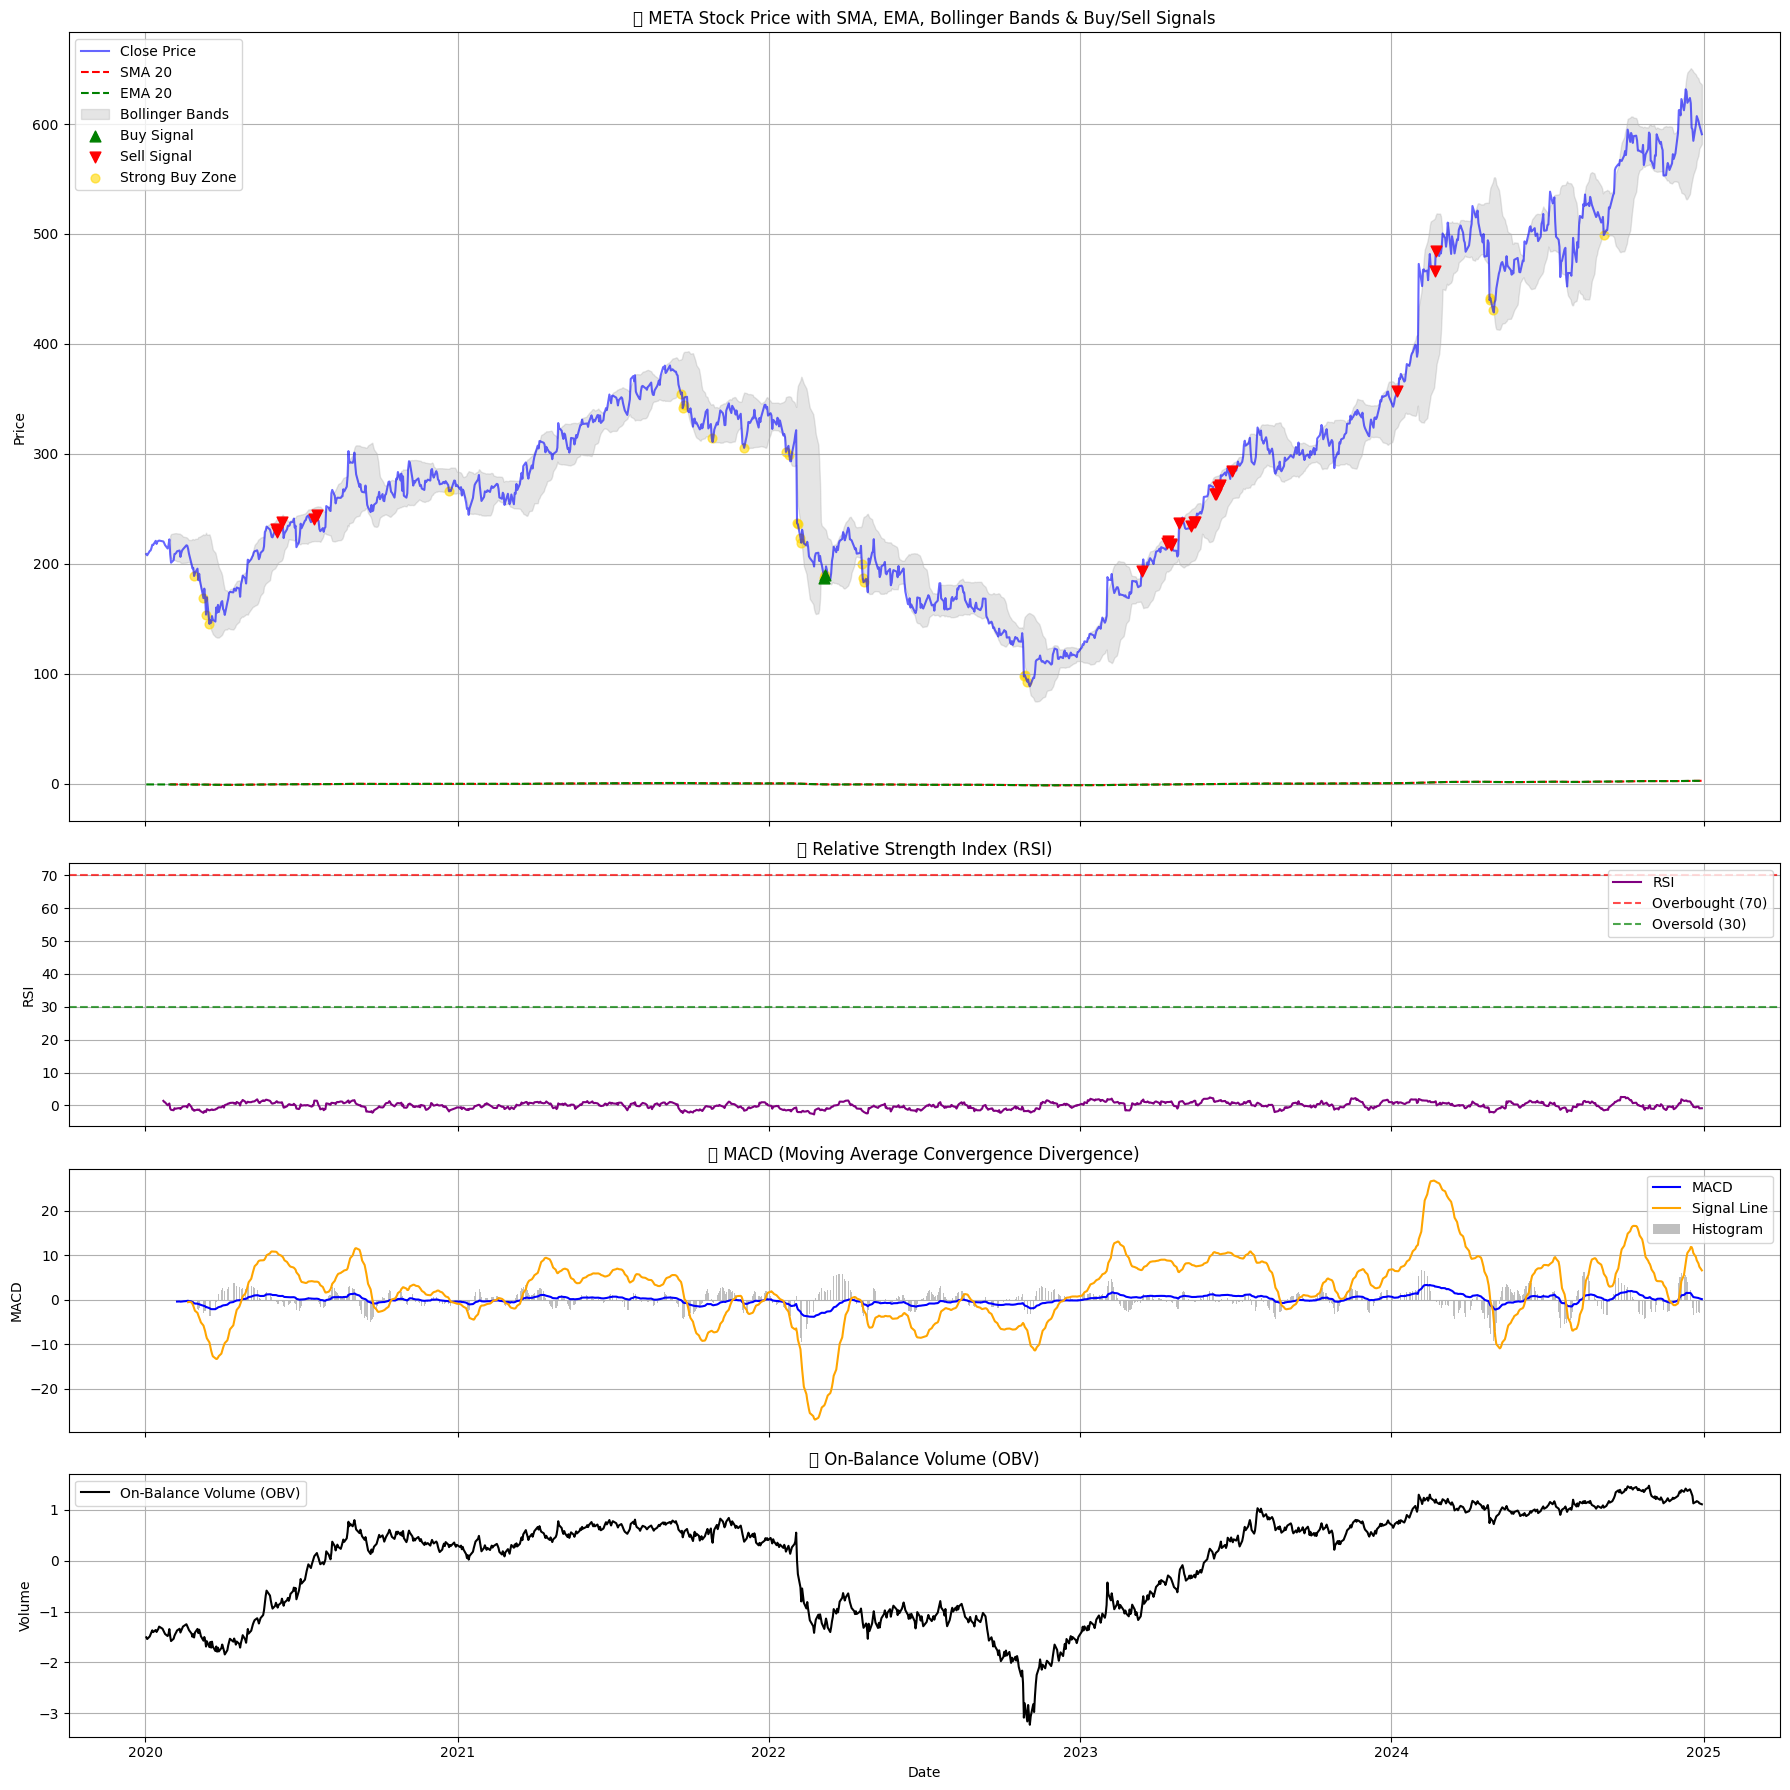

In [ ]:
import matplotlib.pyplot as plt

def plot_stock_with_indicators(df):
    fig, axes = plt.subplots(4, 1, figsize=(18, 18), sharex=True,
                             gridspec_kw={'height_ratios': [3, 1, 1, 1]})

    # ========================
    # 📈 Subplot 1: Price Chart
    # ========================
    ax1 = axes[0]
    ax1.plot(df.index, df['Close'], label='Close Price', color='blue', alpha=0.6)
    ax1.plot(df.index, df['SMA_20'], label='SMA 20', color='red', linestyle='--')
    ax1.plot(df.index, df['EMA_20'], label='EMA 20', color='green', linestyle='--')
    ax1.fill_between(df.index, df['Lower Band'], df['Upper Band'], color='gray', alpha=0.2, label='Bollinger Bands')

    # ✅ Buy & Sell markers
    ax1.scatter(df.index[df['Buy_Signal']], df['Close'][df['Buy_Signal']], marker='^', color='green', label='Buy Signal', s=60, zorder=5)
    ax1.scatter(df.index[df['Sell_Signal']], df['Close'][df['Sell_Signal']], marker='v', color='red', label='Sell Signal', s=60, zorder=5)

    # 🌟 Strong Buy zones
    ax1.scatter(df.index[df['Strong_Buy']], df['Close'][df['Strong_Buy']], marker='o', color='gold', s=40, label='Strong Buy Zone', alpha=0.6)

    ax1.set_title("📈 META Stock Price with SMA, EMA, Bollinger Bands & Buy/Sell Signals")
    ax1.set_ylabel("Price")
    ax1.legend()
    ax1.grid(True)

    # ========================
    # 📊 Subplot 2: RSI
    # ========================
    ax2 = axes[1]
    ax2.plot(df.index, df['RSI'], label='RSI', color='purple')
    ax2.axhline(70, linestyle="--", color="red", alpha=0.7, label="Overbought (70)")
    ax2.axhline(30, linestyle="--", color="green", alpha=0.7, label="Oversold (30)")
    ax2.set_title("📊 Relative Strength Index (RSI)")
    ax2.set_ylabel("RSI")
    ax2.legend()
    ax2.grid(True)

    # ========================
    # 📉 Subplot 3: MACD
    # ========================
    ax3 = axes[2]
    ax3.plot(df.index, df['MACD'], label='MACD', color='blue')
    ax3.plot(df.index, df['MACD_signal'], label='Signal Line', color='orange')
    ax3.bar(df.index, df['MACD_diff'], label='Histogram', color='gray', alpha=0.5)
    ax3.set_title("📉 MACD (Moving Average Convergence Divergence)")
    ax3.set_ylabel("MACD")
    ax3.legend()
    ax3.grid(True)

    # ========================
    # 🔊 Subplot 4: OBV
    # ========================
    ax4 = axes[3]
    ax4.plot(df.index, df['OBV'], label='On-Balance Volume (OBV)', color='black')
    ax4.set_title("📈 On-Balance Volume (OBV)")
    ax4.set_ylabel("Volume")
    ax4.set_xlabel("Date")
    ax4.legend()
    ax4.grid(True)

    plt.tight_layout()
    plt.show()

# ✅ To run the chart:
plot_stock_with_indicators(df)


In [ ]:
from google.colab import files  # Import the files module

uploaded = files.upload()  # Opens a file picker

Saving F-F_Research_Data_5_Factors_2x3_daily.CSV to F-F_Research_Data_5_Factors_2x3_daily (1).CSV


In [ ]:
# Read Fama-French 5 Factors CSV with metadata skipped
data_ff5 = pd.read_csv("F-F_Research_Data_5_Factors_2x3_daily.CSV", skiprows=3)

# Remove footer if exists
data_ff5 = data_ff5.dropna(how='all')

# Rename the date column if needed
if 'Unnamed: 0' in data_ff5.columns:
    data_ff5.rename(columns={'Unnamed: 0': 'date'}, inplace=True)

# Convert date string to datetime
data_ff5['date'] = data_ff5['date'].astype(str).str[:4] + '-' + \
                   data_ff5['date'].astype(str).str[4:6] + '-' + \
                   data_ff5['date'].astype(str).str[6:8]
data_ff5['date'] = pd.to_datetime(data_ff5['date'], errors='coerce')

# Drop rows with invalid dates
data_ff5 = data_ff5.dropna(subset=['date'])

# Set index
df_ffs = data_ff5.set_index('date')

df_ffs.head()


Mkt-RF   SMB   HML   RMW   CMA     RF
date                                             
1963-07-01   -0.67  0.02 -0.35  0.03  0.13  0.012
1963-07-02    0.79 -0.28  0.28 -0.08 -0.21  0.012
1963-07-03    0.63 -0.18 -0.10  0.13 -0.25  0.012
1963-07-05    0.40  0.09 -0.28  0.07 -0.30  0.012
1963-07-08   -0.63  0.07 -0.20 -0.27  0.06  0.012

In [ ]:
from google.colab import files  # Import the files module

uploaded = files.upload()  # Opens a file picker

Saving ADS_Index_Most_Current_Vintage (1).xlsx to ADS_Index_Most_Current_Vintage (1) (1).xlsx


In [ ]:
import pandas as pd

# Use the actual uploaded file name
ads_file = list(uploaded.keys())[0]  # dynamically get uploaded filename

# Load the ADS index with correct header skip and column names
data_ads = pd.read_excel(ads_file, skiprows=1, names=['date', 'ADS_Index'])

# Convert date format 'YYYY:MM:DD' → datetime
data_ads['date'] = pd.to_datetime(data_ads['date'], format='%Y:%m:%d', errors='coerce')

# Drop rows with invalid date
data_ads.dropna(subset=['date'], inplace=True)

# Set date as index
df_ads = data_ads.set_index('date')

# Preview
df_ads.head()


ADS_Index
date                 
1960-03-02  -0.626419
1960-03-03  -0.672386
1960-03-04  -0.715224
1960-03-05  -0.754950
1960-03-06  -0.791579

In [ ]:
from google.colab import files  # Import the files module

uploaded = files.upload()  # Opens a file picker

In [ ]:
# 🔁 Step 0: Install FRED API if not already installed
!pip install fredapi --quiet

# 📦 Step 1: Import required libraries
import pandas as pd
from fredapi import Fred

# 🔑 Step 2: Authenticate with your API key
fred = Fred(api_key='a290a176af8b86e8bfcb4e35d8939893')  # 🔁 Replace with your actual key

# 🧠 Step 3: Define macroeconomic features relevant to META
varList_meta = [
    'T10Y3M',         # Term spread
    'T10YIE',         # Inflation expectations
    'VIXCLS',         # Volatility Index
    'DGS10',          # 10-Year Treasury Rate
    'DCOILWTICO',     # Crude Oil (WTI)
    'DEXUSEU',        # USD to Euro exchange rate
    'BAMLH0A0HYM2',   # High yield bond spread
    'SP500',          # S&P 500 Index
    'CBBTCUSD',       # Bitcoin price
    'CPILFESL'        # Core CPI (monthly, will be forward-filled)
]

# 📥 Step 4: Fetch and merge all series
df_fred = pd.DataFrame()

for code in varList_meta:
    series = fred.get_series(code)
    series.name = code
    df_fred = pd.merge(df_fred, series, left_index=True, right_index=True, how='outer') if not df_fred.empty else series.to_frame()

# 📅 Step 5: Resample to business daily frequency and forward-fill
#df_fred = df_fred.sort_index()
#df_fred = df_fred.resample('B').ffill()

# 📆 Step 6: Filter to your desired range
df_fred = df_fred.loc['2020-01-01':'2024-12-31']

# 🚫 Step 7: Drop any remaining NaN columns (shouldn't be needed if series are valid)
#df_fred = df_fred.dropna(axis=1, how='all')

# 💾 Step 8: Save to CSV
df_fred.to_csv("FRED_Macro_Cleaned_META_2020_2024.csv")
print("✅ Saved as: FRED_Macro_Cleaned_META_2020_2024.csv")

# 🖼️ Step 9: Preview first few rows
df_fred.head()


✅ Saved as: FRED_Macro_Cleaned_META_2020_2024.csv


T10Y3M  T10YIE  VIXCLS  DGS10  DCOILWTICO  DEXUSEU  BAMLH0A0HYM2  \
2020-01-01     NaN     NaN     NaN    NaN         NaN      NaN           NaN   
2020-01-02    0.34    1.80   12.47   1.88       61.17   1.1166          3.56   
2020-01-03    0.28    1.77   14.02   1.80       63.00   1.1173          3.61   
2020-01-04     NaN     NaN     NaN    NaN         NaN      NaN           NaN   
2020-01-05     NaN     NaN     NaN    NaN         NaN      NaN           NaN   

              SP500  CBBTCUSD  CPILFESL  
2020-01-01      NaN   7174.32   266.716  
2020-01-02  3257.85   6945.01       NaN  
2020-01-03  3234.85   7335.54       NaN  
2020-01-04      NaN   7353.50       NaN  
2020-01-05      NaN   7348.69       NaN

In [ ]:
!pip install pytrends --quiet
from pytrends.request import TrendReq
import pandas as pd

# Step 1: Initialize pytrends
pytrends = TrendReq(hl='en-US', tz=360)

# Step 2: Select search terms
keywords = ["Meta", "Facebook", "Instagram", "WhatsApp", "Threads"]

# Step 3: Build the query for US, daily granularity
import time
pytrends.build_payload(kw_list=keywords, geo='US', timeframe='2020-01-01 2024-12-31')
time.sleep(5)

# Step 4: Get daily interest over time
trend_data = pytrends.interest_over_time()

# Step 5: Clean and preview
if 'isPartial' in trend_data.columns:
    trend_data = trend_data.drop(columns=['isPartial'])

trend_data.reset_index(inplace=True)
trend_data.to_csv("Meta_GoogleTrends_2020_2024.csv", index=False)
from google.colab import files
files.download("Meta_GoogleTrends_2020_2024.csv")

# Preview
trend_data.tail()



TooManyRequestsError: The request failed: Google returned a response with code 429

In [ ]:
!pip install newsapi-python textblob --quiet
from newsapi import NewsApiClient
from textblob import TextBlob
import pandas as pd
from datetime import datetime, timedelta


In [ ]:
# Initialize with your NewsAPI key
newsapi = NewsApiClient(api_key='a4e4cc08c9574fb99cfdde03f6cc7d09')

# Define timeframe
start_date = datetime(2025, 4, 1)   # Threads milestone
end_date = datetime(2025, 4, 14)

results = []

# Loop day by day
while start_date <= end_date:
    date_str = start_date.strftime('%Y-%m-%d')

    articles = newsapi.get_everything(
        q="Meta OR Facebook OR Zuckerberg",
        from_param=date_str,
        to=date_str,
        language='en',
        sort_by='relevancy',
        page_size=100
    )

    # Analyze each headline's sentiment
    for article in articles['articles']:
        title = article['title']
        polarity = TextBlob(title).sentiment.polarity
        results.append({'Date': date_str, 'Title': title, 'Polarity': polarity})

    start_date += timedelta(days=1)

# Convert to DataFrame and aggregate
df_news = pd.DataFrame(results)
df_news['Date'] = pd.to_datetime(df_news['Date'])
daily_sentiment = df_news.groupby('Date')['Polarity'].mean().reset_index()
daily_sentiment.columns = ['Date', 'Avg_News_Sentiment']

# Save and preview
daily_sentiment.to_csv("Meta_News_Sentiment.csv", index=False)
from google.colab import files
files.download("Meta_News_Sentiment.csv")

daily_sentiment.head(20)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Date  Avg_News_Sentiment
0  2025-04-01            0.062494
1  2025-04-02            0.062558
2  2025-04-03            0.075930
3  2025-04-04            0.080833
4  2025-04-05            0.049766
5  2025-04-06            0.057339
6  2025-04-07            0.091064
7  2025-04-08            0.045407
8  2025-04-09            0.033317
9  2025-04-10            0.031760
10 2025-04-11            0.085608
11 2025-04-12            0.075879
12 2025-04-13            0.075320
13 2025-04-14            0.037195

In [ ]:
from google.colab import files  # Import the files module

uploaded = files.upload()  # Opens a file picker

Saving Meta_News_Sentiment.csv to Meta_News_Sentiment (2).csv


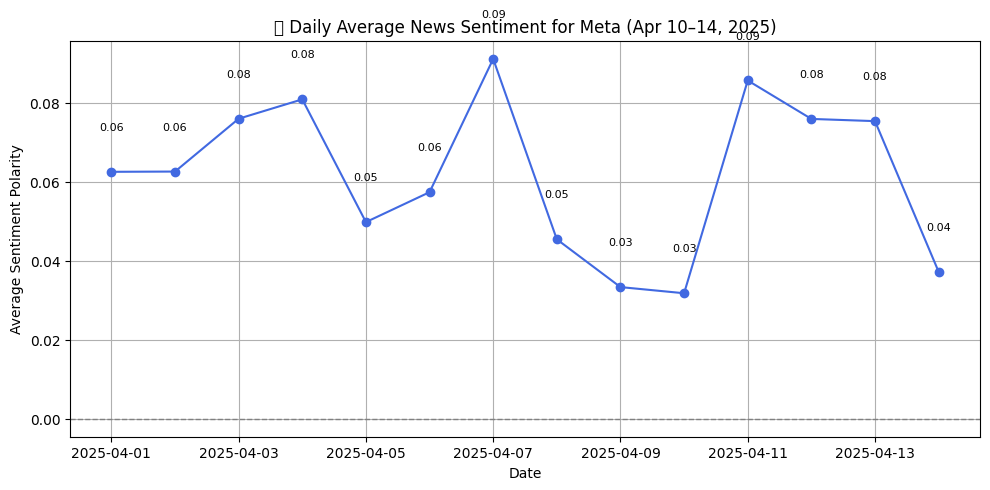

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 📥 Load the sentiment CSV
sentiment_df = pd.read_csv("Meta_News_Sentiment.csv", parse_dates=['Date'])

# 📊 Plot the daily sentiment
plt.figure(figsize=(10, 5))
plt.plot(sentiment_df['Date'], sentiment_df['Avg_News_Sentiment'], marker='o', linestyle='-', color='royalblue')

# 🏷️ Labels and title
plt.title("📰 Daily Average News Sentiment for Meta (Apr 10–14, 2025)")
plt.xlabel("Date")
plt.ylabel("Average Sentiment Polarity")
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

# 📅 Annotate points
for i, row in sentiment_df.iterrows():
    plt.text(row['Date'], row['Avg_News_Sentiment'] + 0.01, f"{row['Avg_News_Sentiment']:.2f}",
             ha='center', va='bottom', fontsize=8)

plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# === Step 0: Imports ===
import pandas as pd
import numpy as np
import time
from pytrends.request import TrendReq

# === Step 1: Set Date Range ===
start_date = '2020-01-01'
end_date = '2024-12-31'

# === Step 2: Load Full Technical Feature Mart (55 features) ===
base_df = pd.read_csv("META_FeatureMart_2020_2024.csv")
base_df['Date'] = pd.to_datetime(base_df['Date']).dt.date

# === Step 3: Filter & Merge Macro Data (FF5 + ADS + FRED) ===
df_ffs_filtered = df_ffs.loc[(df_ffs.index >= start_date) & (df_ffs.index <= end_date)]
macro_df = pd.merge(df_ffs_filtered, df_ads, left_index=True, right_index=True, how='outer')
macro_df = pd.merge(macro_df, df_fred, left_index=True, right_index=True, how='outer')
macro_df = macro_df.loc[(macro_df.index >= start_date) & (macro_df.index <= end_date)]
macro_df = macro_df.ffill().reset_index()

# Rename to standard column
if 'index' in macro_df.columns:
    macro_df.rename(columns={'index': 'Date'}, inplace=True)
elif 'date' in macro_df.columns:
    macro_df.rename(columns={'date': 'Date'}, inplace=True)

macro_df['Date'] = pd.to_datetime(macro_df['Date']).dt.date

# === Step 4: Fetch Google Trends ===
pytrends = TrendReq(hl='en-US', tz=360)
keywords = ["Meta", "Facebook", "Instagram", "WhatsApp", "Threads"]
pytrends.build_payload(kw_list=keywords, geo='US', timeframe=f'{start_date} {end_date}')
trend_data = pytrends.interest_over_time().drop(columns='isPartial')

# Fix trend dates
trend_data.index = pd.to_datetime(trend_data.index).to_series().dt.date
trend_data.index.name = None
all_days = pd.date_range(start=start_date, end=end_date, freq='D').date
trend_data_daily = trend_data.reindex(all_days).ffill().reset_index().rename(columns={'index': 'Date'})

# === Step 5: Merge Macro + Trends ===
macro_trend_df = pd.merge(macro_df, trend_data_daily, how='left', on='Date')
macro_trend_df.fillna(method='ffill', inplace=True)

# === Step 6: Merge with Base Feature Mart ===
final_df = pd.merge(base_df, macro_trend_df, how='left', on='Date')
final_df = final_df.dropna(subset=['Date'])

# === Step 7: Save CSV ===
final_df.to_csv("META_FeatureMart_2020_2024_FULL.csv", index=False)
print("✅ All features (technical + macro + trends) saved as META_FeatureMart_2020_2024_FULL.csv")

# Download (if in Google Colab)
from google.colab import files
files.download("META_FeatureMart_2020_2024_FULL.csv")


TooManyRequestsError: The request failed: Google returned a response with code 429

In [ ]:
from datetime import datetime
import pandas as pd

# load feature data
start_date = datetime(2020, 1, 1)
end_date = datetime(2024, 12, 31)

data_raw = pd.read_csv('META_FeatureMart_2020_2024_FULL.csv', index_col=0)
data_raw.index = pd.to_datetime(data_raw.index)  # Ensure index is datetime
data_raw = data_raw.loc[start_date:end_date]

X_raw = data_raw.fillna(method='bfill')  # backfill NA values
X = pd.DataFrame(index=X_raw.index)

# preprocess data using min-max scaling
# Select only numeric columns
numeric_cols = X_raw.select_dtypes(include=[np.number]).columns

# Initialize X with only numeric columns
X = pd.DataFrame(index=X_raw.index)

# Min-max normalize numeric features
for col in numeric_cols:
    X[col] = (X_raw[col] - X_raw[col].min()) / (X_raw[col].max() - X_raw[col].min())



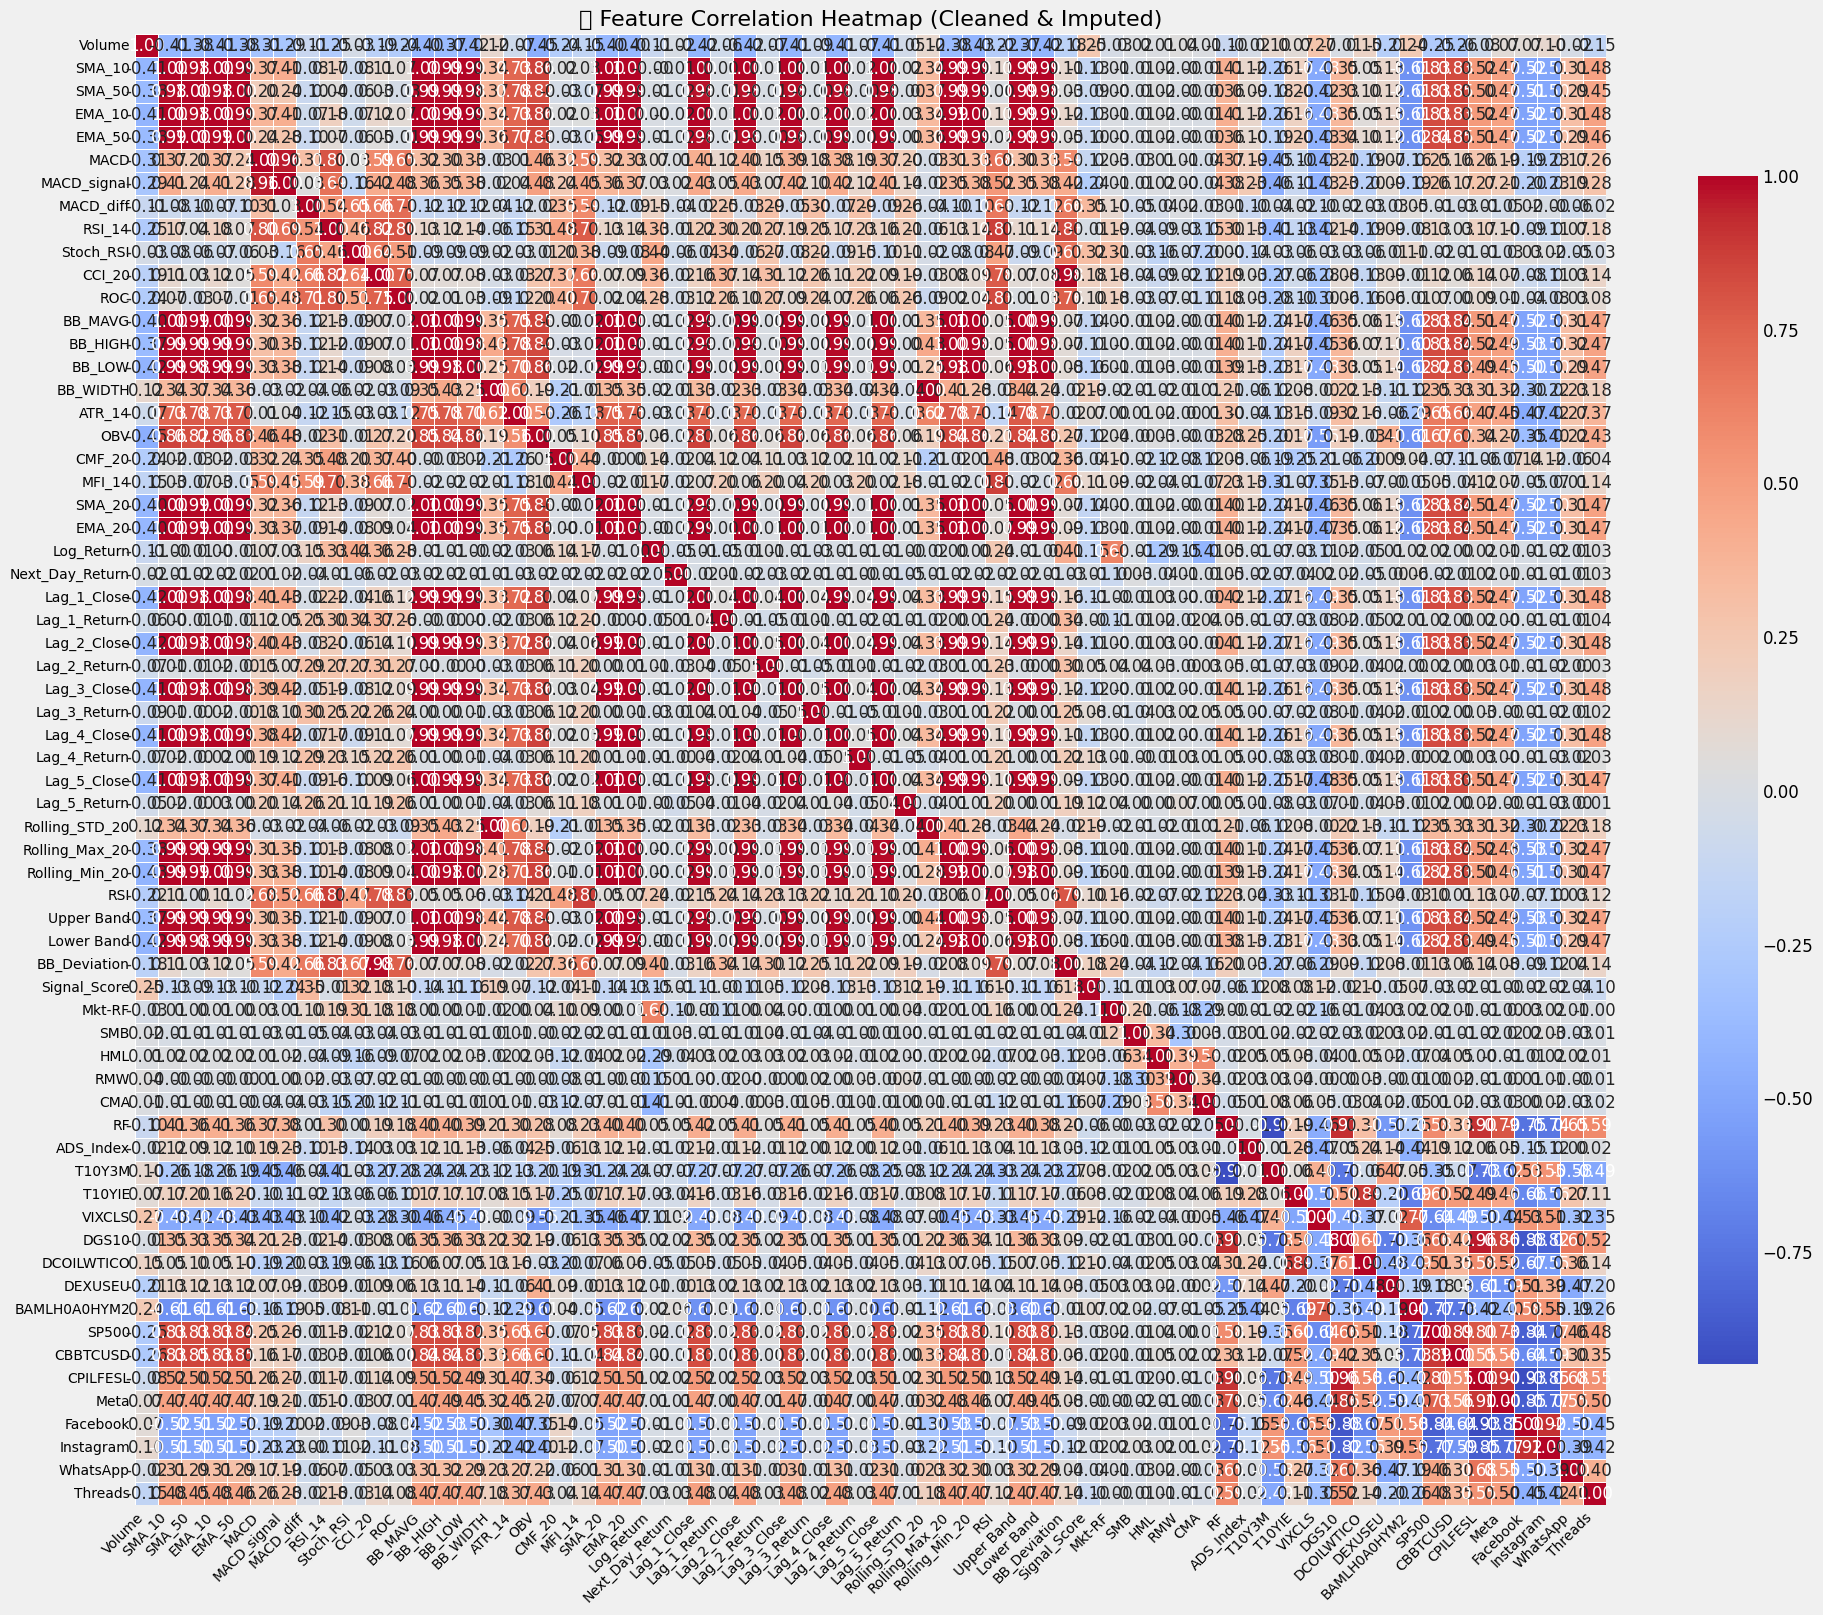

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter only numerical columns
corr = X.select_dtypes(include=[np.number]).corr()

# Plot improved heatmap
plt.figure(figsize=(20, 18))  # Bigger figure for clarity
sns.heatmap(
    corr,
    cmap='coolwarm',
    annot=True,           # Turn off annotations to reduce clutter
    fmt='.2f',
    square=True,
    cbar_kws={"shrink": 0.7},
    linewidths=0.4)

plt.title("📊 Feature Correlation Heatmap (Cleaned & Imputed)", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()


## 🧾 META Feature Mart: Full Feature Explanation (2020-2024)

This document provides a detailed explanation of every feature included in the `META_FeatureMart_2020_2024_FULL.csv`. Each feature is categorized, explained in terms of its purpose, and justified in the context of predicting Meta stock movement.

---

### 📊 Price Data
- **Open, High, Low, Close**: Core stock price information used in nearly all technical analysis.
- **Volume**: Total shares traded, often a signal of market strength or weakness.

These serve as the foundation for technical indicators and give context to price trends.

---

### 📈 Trend Indicators
- **SMA_10, SMA_20, SMA_50**: Simple Moving Averages help identify short, medium, and long-term price trends.
- **EMA_10, EMA_20, EMA_50**: Exponential MAs place more weight on recent data; react faster to price shifts.
- **MACD, MACD_signal, MACD_diff**: Measure convergence/divergence between short/long EMAs. Useful for trend reversals.

Meta’s price trend is often momentum-driven during events like earnings, launches, or market rotations, making these features valuable.

---

### 🔁 Momentum Indicators
- **RSI_14**: Measures recent gains/losses to identify overbought/oversold zones.
- **Stoch_RSI**: Stochastic version of RSI; highly sensitive.
- **CCI_20**: Commodity Channel Index — measures price deviation from mean.
- **ROC**: Rate of Change — velocity of price change.

Momentum indicators help detect rapid investor sentiment changes.

---

### ⚡ Volatility Indicators
- **BB_MAVG, BB_HIGH, BB_LOW, BB_WIDTH**: Bollinger Bands show volatility boundaries.
- **ATR_14**: Average True Range — average intraday volatility.

Volatility surges during earnings or product announcements are crucial for understanding Meta stock moves.

---

### 📦 Volume Indicators
- **OBV**: On-Balance Volume — momentum based on volume.
- **CMF_20**: Chaikin Money Flow — shows money inflow/outflow.
- **MFI_14**: Money Flow Index — combines price + volume for momentum.

Volume signals the conviction behind price movements.

---

### 📈 Returns & Lags
- **Log_Return, Next_Day_Return**: Daily return metrics.
- **Lag_1_5_Close/Return**: Previous days’ prices and returns.
- **Return_3D, Return_7D**: Forward returns (used in label creation).

These features help build return-based predictive and classification models.

---

### 🔁 Rolling Stats
- **Rolling_STD_20**: 20-day volatility.
- **Rolling_Max_20, Rolling_Min_20**: Rolling support/resistance levels.

Rolling measures smooth out short-term noise and highlight recent trends.

---

### 🧮 Feature Interactions
- **SMA_vs_EMA**: Captures relative momentum.
- **BB_Deviation**: Position of price within Bollinger Bands.

Engineered features often improve model signal quality.

---

### ✅ Buy/Sell Signals
- **Buy_Signal, Sell_Signal**: Binary signals based on RSI & MACD.
- **Strong_Buy**: High-confidence buy zones.
- **Signal_Score**: Aggregated score combining multiple buy conditions.

Used for generating actionable labels or filtered trading signals.

---

### 📉 Fama-French Factors
- **Mkt-RF, SMB, HML, RMW, CMA, RF**: Capture risk premia across market, size, value, profitability, investment, and risk-free rate.

These are foundational in asset pricing models and academic research. They explain return variation from a fundamental perspective.

---

### 📉 ADS Index
- **ADS_Index**: Aruoba-Diebold-Scotti business conditions index (real-time macroeconomic conditions).

Higher ADS values suggest improving macro outlooks, which can boost Meta’s valuation.

---

### 🏦 FRED Macro
- **T10Y3M, T10YIE, VIXCLS, DGS10**: Yield spreads, inflation expectations, implied volatility.
- **DCOILWTICO**: Oil prices affect input/transportation costs.
- **DEXUSEU, BAMLH0A0HYM2**: FX rates & bond yields, impacting global revenue exposure.
- **SP500**: Benchmark equity market.
- **CBBTCUSD**: Crypto correlation.
- **CPILFESL**: Core inflation measure.

Macro data gives context for Meta’s performance within the broader economy.

---

### 🌐 Google Trends
- **Meta, Facebook, Instagram, WhatsApp, Threads**: Search frequency data — real-time public interest.

Spikes may precede price action (e.g., Threads launch or WhatsApp outage).

---

### 🧠 Summary
These features were carefully curated to combine:
- 🔍 Technical analysis
- 📊 Statistical signals
- 🧾 Fundamental & macroeconomic context
- 🌐 Public interest

Together, they form a robust foundation for predicting Meta stock price behavior using ML models or statistical frameworks.

Let me know if you want a ranking of top predictors or a PCA-based dimensionality reduction next!



# **Regression Models**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, Lars
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def print_header(title):
    print(f" {title} ")
    print("="*80)

data = pd.read_csv('META_FeatureMart_2020_2024_FULL.csv')
print(f"Data shape: {data.shape}")

data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')

data = data.fillna(method='bfill').fillna(method='ffill')

for col in data.columns:
    if data[col].isna().any():
        if data[col].dtype in ['float64', 'int64']:
            data[col] = data[col].fillna(data[col].median())
        else:
            data[col] = data[col].fillna('unknown')

target = 'Close'


print(f"\nTarget Variable: {target}")
print("Target descriptive statistics:")
print(data[target].describe())

Data shape: (1257, 77)

Target Variable: Close
Target descriptive statistics:
count    1257.000000
mean      299.975415
std       124.602584
min        88.492935
25%       208.795944
50%       279.512604
75%       344.665619
max       631.608154
Name: Close, dtype: float64


In [ ]:
exclude_cols = [
    'Date', target, 'Open', 'High', 'Low', 'Target_3D', 'Target_7D',
    'Return_3D', 'Return_7D', 'Volatility_Level'
]

numeric_cols = data.select_dtypes(include=[np.number]).columns
feature_cols = [col for col in numeric_cols if col not in exclude_cols]

bool_cols = data.select_dtypes(include=['bool']).columns
feature_cols = [col for col in feature_cols if col not in bool_cols]

In [ ]:
X = data[feature_cols]
y = data[target]

print(f"\nInitial feature set: {len(feature_cols)} features")


train_size = int(len(data) * 0.8)
X_train = X.iloc[:train_size]
X_test = X.iloc[train_size:]
y_train = y.iloc[:train_size]
y_test = y.iloc[train_size:]

print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)


Initial feature set: 64 features
Training set: (1005, 64), Test set: (252, 64)


In [ ]:
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)

    print(f"\nOut-of-Sample Performance for {model_name}:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")

    return {
        'Model': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2
    }

In [ ]:
results = []
print_header("CORRELATION-BASED FEATURE SELECTION")

correlation = {}
for col in feature_cols:
    correlation[col] = abs(data[col].corr(y))

correlation_sorted = sorted(correlation.items(), key=lambda x: x[1], reverse=True)

top_n = 15
corr_features = [x[0] for x in correlation_sorted[:top_n]]

print(f"Top {top_n} features by correlation with Close price:")
for i, (feature, corr) in enumerate(correlation_sorted[:top_n], 1):
    print(f"{i}. {feature}: {corr:.4f}")

X_train_corr = X_train_scaled_df[corr_features]
X_test_corr = X_test_scaled_df[corr_features]

X_train_corr_const = sm.add_constant(X_train_corr)
X_test_corr_const = sm.add_constant(X_test_corr)

 CORRELATION-BASED FEATURE SELECTION 
Top 15 features by correlation with Close price:
1. Lag_1_Close: 0.9981
2. EMA_10: 0.9968
3. Lag_2_Close: 0.9964
4. SMA_10: 0.9955
5. Lag_3_Close: 0.9948
6. Lag_4_Close: 0.9932
7. EMA_20: 0.9931
8. Lag_5_Close: 0.9917
9. SMA_20: 0.9906
10. BB_MAVG: 0.9906
11. Rolling_Min_20: 0.9900
12. Rolling_Max_20: 0.9882
13. BB_LOW: 0.9865
14. Lower Band: 0.9862
15. BB_HIGH: 0.9850


In [ ]:
print_header("RIDGE REGRESSION WITH CORRELATION-SELECTED FEATURES")

alpha_ridge = 1.0
try:
    ridge_model = sm.OLS(y_train, X_train_corr_const).fit_regularized(
        method='elastic_net',
        alpha=alpha_ridge,
        L1_wt=0.0
    )

    print(f"\nRidge Regression Results (alpha = {alpha_ridge}):")
    print(f"Coefficients:")
    ridge_features = []
    for feature, coef in zip(['const'] + corr_features, ridge_model.params):
        print(f"- {feature}: {coef:.6f}")
        if abs(coef) > 1e-5:
            ridge_features.append(feature)

    if 'const' not in ridge_features:
        ridge_features = ['const'] + ridge_features

    X_train_ridge = X_train_corr_const[ridge_features]
    X_test_ridge = X_test_corr_const[ridge_features]

    ridge_ols_model = sm.OLS(y_train, X_train_ridge).fit()
    print("\nOLS Summary with Ridge-selected features:")
    print(ridge_ols_model.summary())

    y_pred_ridge = ridge_ols_model.predict(X_test_ridge)

    ridge_results = evaluate_model(y_test, y_pred_ridge, "Ridge")
    ridge_results['Features'] = [f for f in ridge_features if f != 'const']
    results.append(ridge_results)

except Exception as e:
    print(f"Error in Ridge regression: {e}")

 RIDGE REGRESSION WITH CORRELATION-SELECTED FEATURES 

Ridge Regression Results (alpha = 1.0):
Coefficients:
- const: 124.044472
- Lag_1_Close: 5.524032
- EMA_10: 4.783438
- Lag_2_Close: 5.101652
- SMA_10: 4.596212
- Lag_3_Close: 4.726552
- Lag_4_Close: 4.444227
- EMA_20: 4.173060
- Lag_5_Close: 4.232440
- SMA_20: 3.918113
- BB_MAVG: 3.918113
- Rolling_Min_20: 4.431079
- Rolling_Max_20: 3.794113
- BB_LOW: 4.310481
- Lower Band: 4.319315
- BB_HIGH: 3.440293

OLS Summary with Ridge-selected features:
                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 5.799e+04
Date:                Wed, 16 Apr 2025   Prob (F-statistic):               0.00
Time:                        20:21:18   Log-Likelihood:                -2410.6
No. Observations:     

In [ ]:
print_header("LASSO REGRESSION WITH CORRELATION-SELECTED FEATURES")

alpha_lasso = 0.01
try:
    lasso_model = sm.OLS(y_train, X_train_corr_const).fit_regularized(
        method='elastic_net',
        alpha=alpha_lasso,
        L1_wt=1.0
    )

    print(f"\nLasso Regression Results (alpha = {alpha_lasso}):")
    print(f"Coefficients:")
    lasso_features = []
    for feature, coef in zip(['const'] + corr_features, lasso_model.params):
        print(f"- {feature}: {coef:.6f}")
        if abs(coef) > 1e-5:
            lasso_features.append(feature)

    print(f"\nLasso selected {len(lasso_features) - ('const' in lasso_features)} features:")
    for feature in lasso_features:
        if feature != 'const':
            print(f"- {feature}")

    if 'const' not in lasso_features:
        lasso_features = ['const'] + lasso_features

    X_train_lasso = X_train_corr_const[lasso_features]
    X_test_lasso = X_test_corr_const[lasso_features]

    lasso_ols_model = sm.OLS(y_train, X_train_lasso).fit()
    print("\nOLS Summary with Lasso-selected features:")
    print(lasso_ols_model.summary())

    y_pred_lasso = lasso_ols_model.predict(X_test_lasso)

    lasso_results = evaluate_model(y_test, y_pred_lasso, "Lasso")
    lasso_results['Features'] = [f for f in lasso_features if f != 'const']
    results.append(lasso_results)

except Exception as e:
    print(f"Error in Lasso regression: {e}")

 LASSO REGRESSION WITH CORRELATION-SELECTED FEATURES 

Lasso Regression Results (alpha = 0.01):
Coefficients:
- const: 248.078944
- Lag_1_Close: 67.054486
- EMA_10: 6.345339
- Lag_2_Close: -3.780747
- SMA_10: 1.907407
- Lag_3_Close: -2.953701
- Lag_4_Close: 0.000000
- EMA_20: 1.626272
- Lag_5_Close: -0.299331
- SMA_20: 0.000000
- BB_MAVG: 0.000000
- Rolling_Min_20: 3.911304
- Rolling_Max_20: 0.000000
- BB_LOW: 0.000000
- Lower Band: 0.000000
- BB_HIGH: -3.539721

Lasso selected 9 features:
- Lag_1_Close
- EMA_10
- Lag_2_Close
- SMA_10
- Lag_3_Close
- EMA_20
- Lag_5_Close
- Rolling_Min_20
- BB_HIGH

OLS Summary with Lasso-selected features:
                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 4.255e+04
Date:                Wed, 16 Apr 202

In [ ]:

print_header("ELASTIC NET REGRESSION WITH CORRELATION-SELECTED FEATURES")

alpha_enet = 0.01
l1_ratio = 0.5
try:
    enet_model = sm.OLS(y_train, X_train_corr_const).fit_regularized(
        method='elastic_net',
        alpha=alpha_enet,
        L1_wt=l1_ratio
    )

    print(f"\nElastic Net Regression Results (alpha = {alpha_enet}, L1_ratio = {l1_ratio}):")
    print(f"Coefficients:")
    enet_features = []
    for feature, coef in zip(['const'] + corr_features, enet_model.params):
        print(f"- {feature}: {coef:.6f}")
        if abs(coef) > 1e-5:
            enet_features.append(feature)

    print(f"\nElastic Net selected {len(enet_features) - ('const' in enet_features)} features:")
    for feature in enet_features:
        if feature != 'const':
            print(f"- {feature}")

    if 'const' not in enet_features:
        enet_features = ['const'] + enet_features

    X_train_enet = X_train_corr_const[enet_features]
    X_test_enet = X_test_corr_const[enet_features]

    enet_ols_model = sm.OLS(y_train, X_train_enet).fit()
    print("\nOLS Summary with ElasticNet-selected features:")
    print(enet_ols_model.summary())

    y_pred_enet = enet_ols_model.predict(X_test_enet)

    enet_results = evaluate_model(y_test, y_pred_enet, "ElasticNet")
    enet_results['Features'] = [f for f in enet_features if f != 'const']
    results.append(enet_results)

except Exception as e:
    print(f"Error in ElasticNet regression: {e}")

 ELASTIC NET REGRESSION WITH CORRELATION-SELECTED FEATURES 

Elastic Net Regression Results (alpha = 0.01, L1_ratio = 0.5):
Coefficients:
- const: 246.849696
- Lag_1_Close: 57.048671
- EMA_10: 17.003878
- Lag_2_Close: -0.741604
- SMA_10: 0.676161
- Lag_3_Close: -2.499611
- Lag_4_Close: 0.000000
- EMA_20: 0.488863
- Lag_5_Close: -0.658498
- SMA_20: 0.000000
- BB_MAVG: 0.000000
- Rolling_Min_20: 4.618189
- Rolling_Max_20: -1.211329
- BB_LOW: 0.000000
- Lower Band: -1.959665
- BB_HIGH: -2.638223

Elastic Net selected 11 features:
- Lag_1_Close
- EMA_10
- Lag_2_Close
- SMA_10
- Lag_3_Close
- EMA_20
- Lag_5_Close
- Rolling_Min_20
- Rolling_Max_20
- Lower Band
- BB_HIGH

OLS Summary with ElasticNet-selected features:
                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-

In [ ]:
print_header("HARD THRESHOLDING WITH CORRELATION-SELECTED FEATURES")
if 'ols_model' not in locals():
    print("OLS model not found. Running OLS model first...")
    ols_model = sm.OLS(y_train, X_train_corr_const).fit()
ht_features = ['const']
for feature in corr_features:
    if feature in ols_model.pvalues and ols_model.pvalues[feature] < 0.05:
        ht_features.append(feature)

if len(ht_features) > 1:
    print(f"Significant features (p < 0.05): {ht_features[1:]}")

    X_train_ht = X_train_corr_const[ht_features]
    X_test_ht = X_test_corr_const[ht_features]

    ht_model = sm.OLS(y_train, X_train_ht).fit()
    print(ht_model.summary())

    y_pred_ht = ht_model.predict(X_test_ht)

    ht_results = evaluate_model(y_test, y_pred_ht, "Hard Thresholding")
    ht_results['Features'] = [f for f in ht_features if f != 'const']
    results.append(ht_results)
else:
    print("No features are significant at p < 0.05. Skipping Hard Thresholding model.")

 HARD THRESHOLDING WITH CORRELATION-SELECTED FEATURES 
Significant features (p < 0.05): ['Lag_1_Close', 'EMA_10', 'Lag_2_Close', 'SMA_10', 'Lag_3_Close', 'Lag_4_Close', 'EMA_20', 'Lag_5_Close', 'Rolling_Max_20']
                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 3.745e+04
Date:                Wed, 16 Apr 2025   Prob (F-statistic):               0.00
Time:                        20:21:42   Log-Likelihood:                -2775.7
No. Observations:                1005   AIC:                             5571.
Df Residuals:                     995   BIC:                             5620.
Df Model:                           9                                         
Covariance Type:            nonrobust                                        

In [ ]:
print_header("LEAST ANGLE REGRESSION WITH CORRELATION-SELECTED FEATURES")
try:
    lars_model = Lars(n_nonzero_coefs=min(len(corr_features), 10))
    lars_model.fit(X_train_corr, y_train)

    print(f"\nLAR Coefficients:")
    lars_features = []
    for i, feature in enumerate(corr_features):
        print(f"- {feature}: {lars_model.coef_[i]:.6f}")
        if abs(lars_model.coef_[i]) > 1e-5:
            lars_features.append(feature)

    print(f"\nLAR selected {len(lars_features)} features:")
    for feature in lars_features:
        print(f"- {feature}")

    if lars_features:
        X_train_lars = X_train_scaled_df[lars_features]
        X_test_lars = X_test_scaled_df[lars_features]

        X_train_lars = sm.add_constant(X_train_lars)
        X_test_lars = sm.add_constant(X_test_lars)

        lars_ols_model = sm.OLS(y_train, X_train_lars).fit()
        print("\nOLS Summary with LAR-selected features:")
        print(lars_ols_model.summary())

        y_pred_lars = lars_ols_model.predict(X_test_lars)

        lars_results = evaluate_model(y_test, y_pred_lars, "LAR")
        lars_results['Features'] = lars_features
        results.append(lars_results)
    else:
        print("LAR did not select any features. Skipping LAR model.")

except Exception as e:
    print(f"Error in LAR regression: {e}")


 LEAST ANGLE REGRESSION WITH CORRELATION-SELECTED FEATURES 

LAR Coefficients:
- Lag_1_Close: 14.635888
- EMA_10: 153.540300
- Lag_2_Close: -6.531742
- SMA_10: 0.000000
- Lag_3_Close: -15.687383
- Lag_4_Close: -10.755965
- EMA_20: 0.000000
- Lag_5_Close: -16.836480
- SMA_20: 0.000000
- BB_MAVG: 0.000000
- Rolling_Min_20: -31.194665
- Rolling_Max_20: 20.602044
- BB_LOW: 0.000000
- Lower Band: 0.000000
- BB_HIGH: -38.655095

LAR selected 9 features:
- Lag_1_Close
- EMA_10
- Lag_2_Close
- Lag_3_Close
- Lag_4_Close
- Lag_5_Close
- Rolling_Min_20
- Rolling_Max_20
- BB_HIGH

OLS Summary with LAR-selected features:
                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 2.398e+04
Date:                Wed, 16 Apr 2025   Prob (F-statistic):         

In [ ]:
print_header("MODEL COMPARISON SUMMARY")

results_df = pd.DataFrame(results)

results_df_sorted = results_df.sort_values('R²', ascending=False)

print("\nModel Performance Comparison (sorted by R²):")
summary_cols = ['Model', 'R²', 'RMSE', 'MAE']
print(results_df_sorted[summary_cols].to_string(index=False))

if not results_df_sorted.empty:
    best_model_idx = results_df_sorted.index[0]
    best_model = results_df_sorted.iloc[0]

    print("\nBest Model Details:")
    print(f"Model Type: {best_model['Model']}")
    print(f"R²: {best_model['R²']:.4f}")
    print(f"RMSE: {best_model['RMSE']:.4f}")

    print("\nSelected Features:")
    for feature in best_model['Features']:
        print(f"- {feature}")

 MODEL COMPARISON SUMMARY 

Model Performance Comparison (sorted by R²):
            Model       R²     RMSE      MAE
       ElasticNet 0.997264 3.288595 2.500379
            Lasso 0.991759 5.706937 4.354113
Hard Thresholding 0.990453 6.142674 4.637608
            Ridge 0.990257 6.205367 5.574575
              LAR 0.983384 8.103852 5.984629

Best Model Details:
Model Type: ElasticNet
R²: 0.9973
RMSE: 3.2886

Selected Features:
- Lag_1_Close
- EMA_10
- Lag_2_Close
- SMA_10
- Lag_3_Close
- EMA_20
- Lag_5_Close
- Rolling_Min_20
- Rolling_Max_20
- Lower Band
- BB_HIGH


# Visualisation of the reg models

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Make sure plots are displayed inline
%matplotlib inline

# Increase default figure size for better visibility
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

In [ ]:
def plot_model_performance_metrics(results_df):

    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='Model', y='R²', data=results_df, palette='Blues_d')

    for i, bar in enumerate(ax.patches):
        ax.text(bar.get_x() + bar.get_width()/2,
                bar.get_height() + 0.001,
                f"{results_df['R²'].iloc[i]:.4f}",
                ha='center')

    plt.title('R² Score by Model', fontsize=16)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='Model', y='RMSE', data=results_df, palette='Reds_d')

    for i, bar in enumerate(ax.patches):
        ax.text(bar.get_x() + bar.get_width()/2,
                bar.get_height() + 0.001,
                f"{results_df['RMSE'].iloc[i]:.4f}",
                ha='center')

    plt.title('RMSE by Model', fontsize=16)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_actual_vs_predicted(y_test, y_pred, model_name):
    plt.figure(figsize=(10, 8))

    plt.scatter(y_test, y_pred, alpha=0.5)

    min_val = min(min(y_test), min(y_pred))
    max_val = max(max(y_test), max(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    plt.text(min_val + 0.05*(max_val-min_val), max_val - 0.1*(max_val-min_val),
             f'R² = {r2:.4f}\nRMSE = {rmse:.4f}',
             bbox=dict(facecolor='white', alpha=0.7))

    plt.title(f'Actual vs Predicted - {model_name}', fontsize=16)
    plt.xlabel('Actual Values', fontsize=14)
    plt.ylabel('Predicted Values', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_time_series(y_test, y_pred, model_name):
    plt.figure(figsize=(14, 7))

    x = range(len(y_test))

    plt.plot(x, y_test.values, 'b-', label='Actual', linewidth=2)
    plt.plot(x, y_pred, 'r-', label='Predicted', linewidth=2)

    plt.fill_between(x, y_test, y_pred, color='gray', alpha=0.2)

    if isinstance(y_test.index, pd.DatetimeIndex):
        tick_indices = np.linspace(0, len(x)-1, min(10, len(x))).astype(int)
        plt.xticks(tick_indices, y_test.index[tick_indices].strftime('%Y-%m-%d'), rotation=45)

    plt.title(f'Time Series of Actual vs Predicted - {model_name}', fontsize=16)
    plt.xlabel('Time Point', fontsize=14)
    plt.ylabel('Close Price', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_feature_count(results_df):
    if 'Features' in results_df.columns:
        feature_counts = []
        for _, row in results_df.iterrows():
            if isinstance(row['Features'], list):
                feature_counts.append(len(row['Features']))
            else:
                feature_counts.append(0)

        count_df = pd.DataFrame({
            'Model': results_df['Model'],
            'Feature Count': feature_counts
        })

        plt.figure(figsize=(12, 6))
        ax = sns.barplot(x='Model', y='Feature Count', data=count_df, palette='Purples_d')

        for i, count in enumerate(feature_counts):
            ax.text(i, count + 0.1, str(count), ha='center')

        plt.title('Number of Features Selected by Each Model', fontsize=16)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

In [ ]:
def plot_feature_selection_overlap(results):
    feature_counts = {}

    for result in results:
        if 'Features' in result and isinstance(result['Features'], list):
            model = result['Model']
            for feature in result['Features']:
                if feature not in feature_counts:
                    feature_counts[feature] = []
                feature_counts[feature].append(model)

    overlap_data = []
    for feature, models in feature_counts.items():
        if len(models) > 0:
            overlap_data.append({
                'Feature': feature,
                'Count': len(models),
                'Models': ', '.join(models)
            })

    if overlap_data:
        overlap_df = pd.DataFrame(overlap_data)
        overlap_df = overlap_df.sort_values('Count', ascending=False)

        if len(overlap_df) > 20:
            overlap_df = overlap_df.head(20)

        plt.figure(figsize=(12, max(6, len(overlap_df) * 0.4)))
        ax = sns.barplot(y='Feature', x='Count', data=overlap_df, palette='Blues_d')

        for i, row in enumerate(overlap_df.itertuples()):
            plt.text(row.Count + 0.1, i, row.Models, va='center', fontsize=8)

        plt.title('Number of Models Selecting Each Feature', fontsize=16)
        plt.xlabel('Number of Models', fontsize=12)
        plt.tight_layout()
        plt.show()


Displaying visualizations...


Feature Selection Overlap:


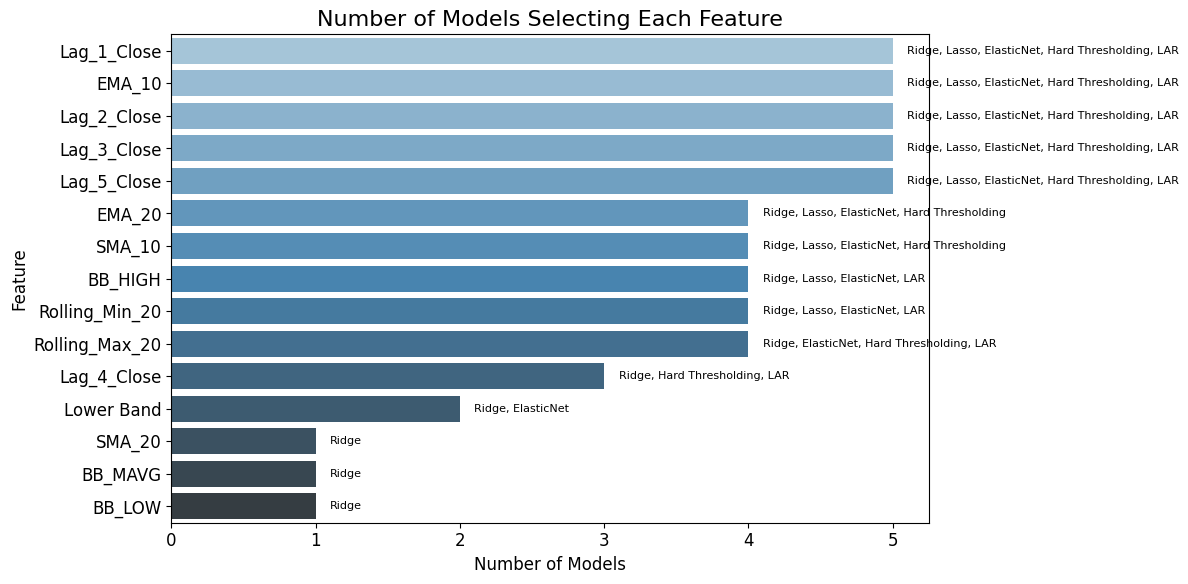

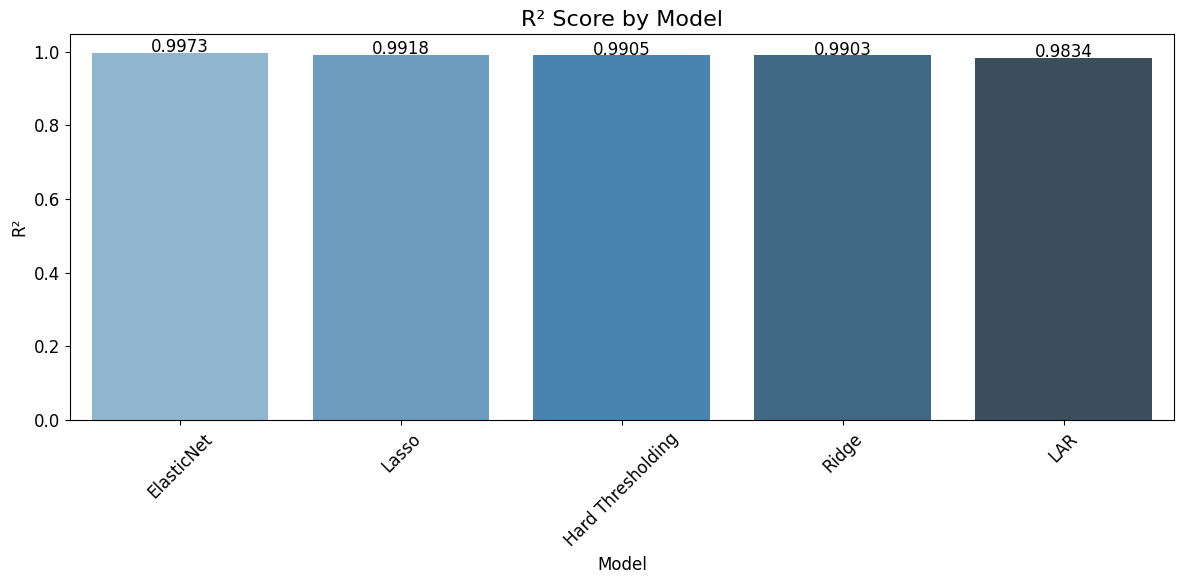

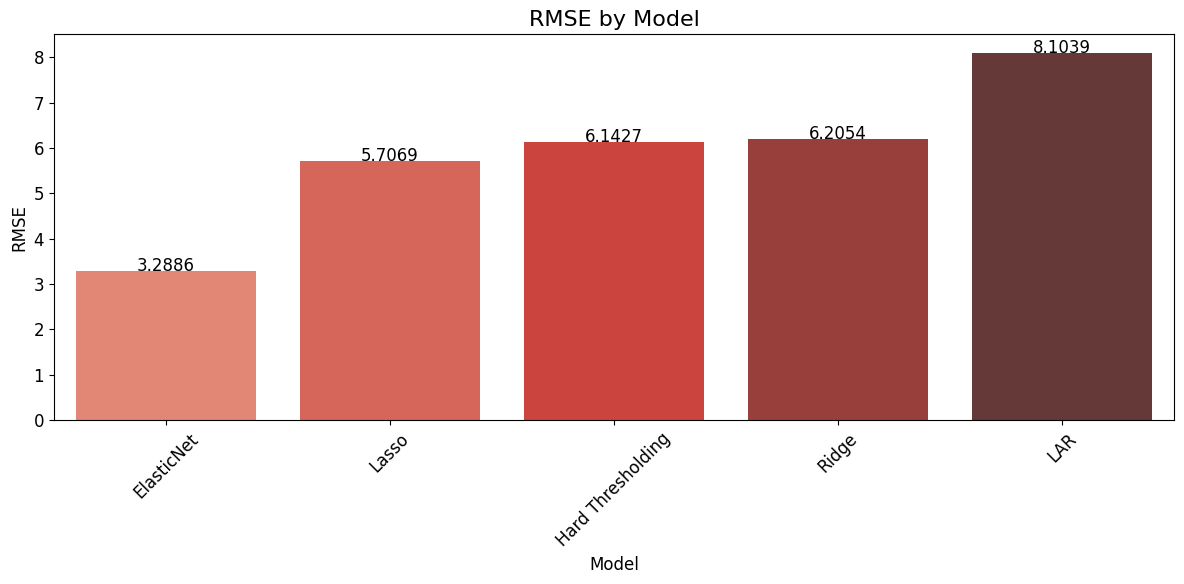


Feature Count by Model:


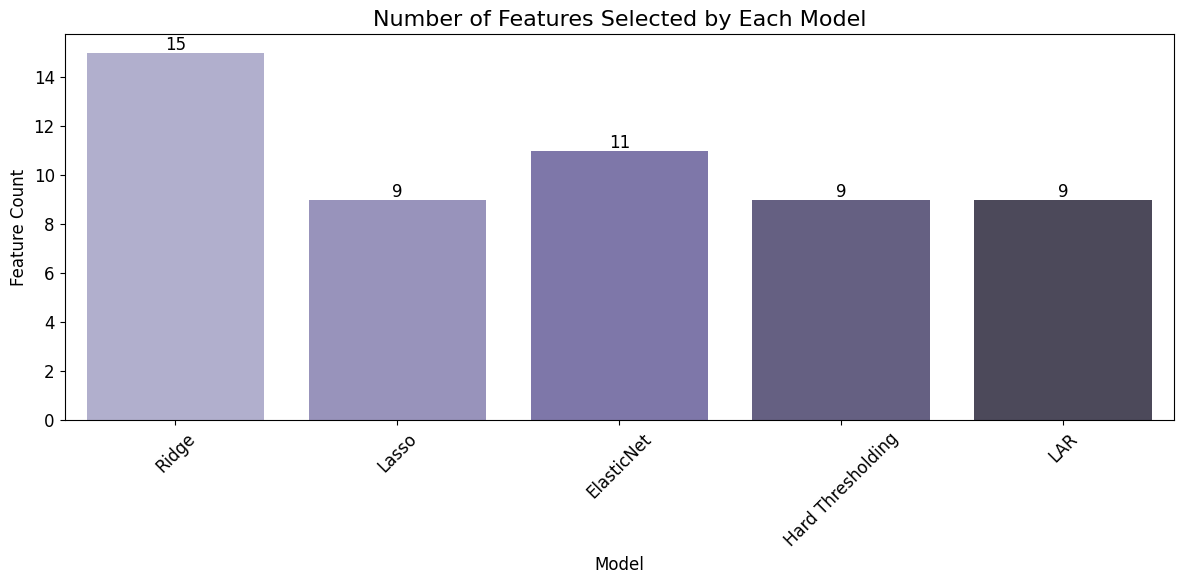


Actual vs Predicted Plot for ElasticNet:


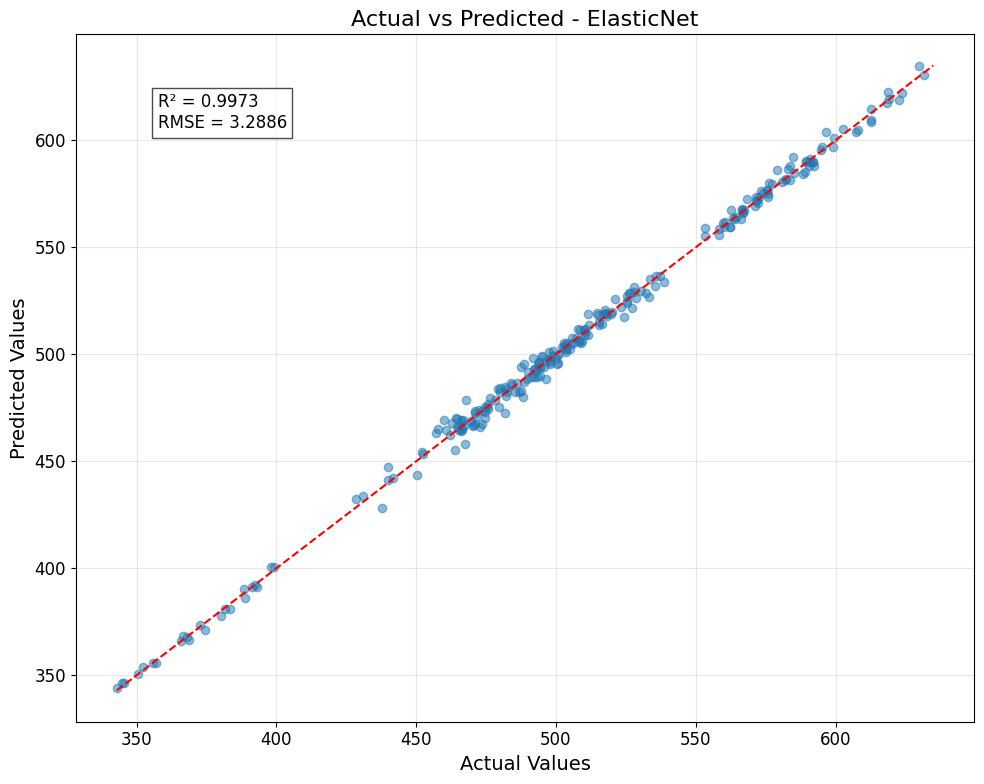


Time Series Plot for ElasticNet:


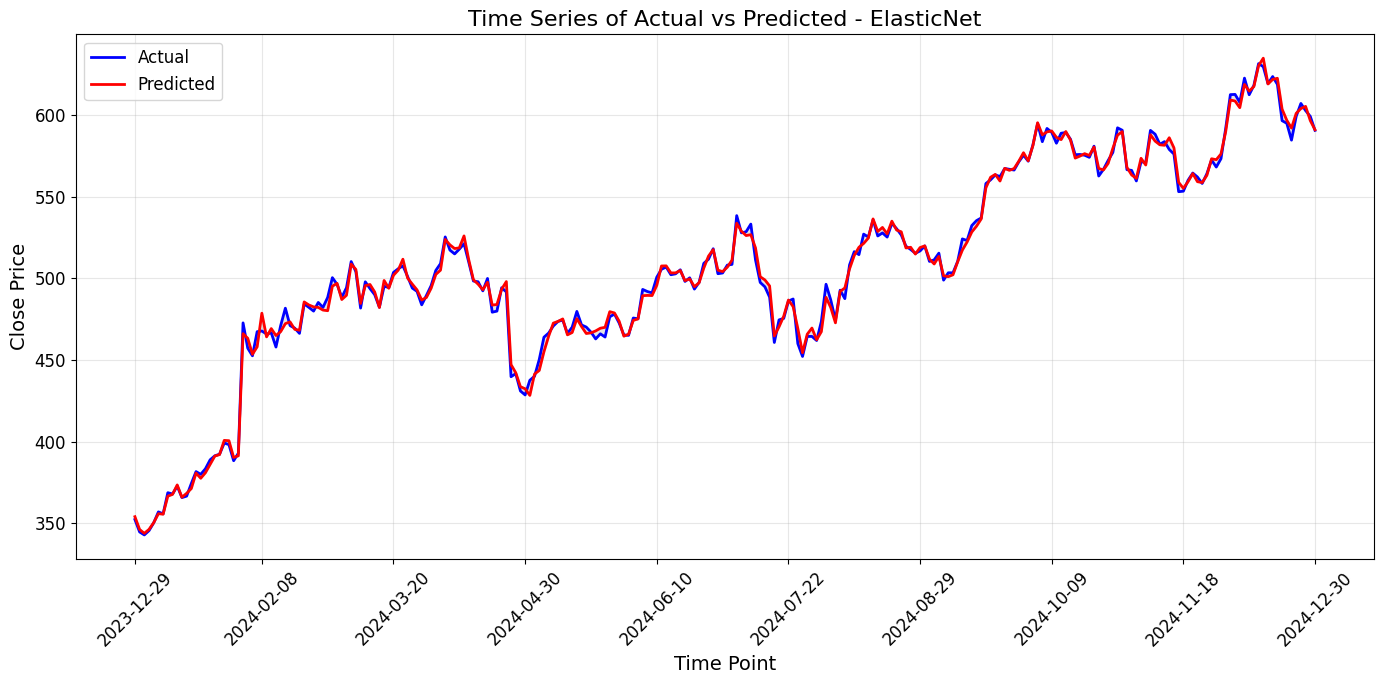

In [ ]:
def display_all_visualizations(data, correlation_sorted, corr_features, results, best_model_predictions=None):
    print("\nDisplaying visualizations...\n")
    print("\nFeature Selection Overlap:")
    plot_feature_selection_overlap(results)

    results_df = pd.DataFrame(results)
    if not results_df.empty:
        results_df_sorted = results_df.sort_values('R²', ascending=False)

        plot_model_performance_metrics(results_df_sorted)

        print("\nFeature Count by Model:")
        plot_feature_count(results_df)

        if best_model_predictions is not None:
            best_model = results_df_sorted.iloc[0]['Model']
            if best_model in best_model_predictions:
                y_test, y_pred = best_model_predictions[best_model]

                print(f"\nActual vs Predicted Plot for {best_model}:")
                plot_actual_vs_predicted(y_test, y_pred, best_model)

                print(f"\nTime Series Plot for {best_model}:")
                plot_time_series(y_test, y_pred, best_model)


best_model_predictions = {}

if 'y_pred_ols' in locals():
    best_model_predictions['OLS'] = (y_test, y_pred_ols)
if 'y_pred_ridge' in locals():
    best_model_predictions['Ridge'] = (y_test, y_pred_ridge)
if 'y_pred_lasso' in locals():
    best_model_predictions['Lasso'] = (y_test, y_pred_lasso)
if 'y_pred_enet' in locals():
    best_model_predictions['ElasticNet'] = (y_test, y_pred_enet)
if 'y_pred_ht' in locals():
    best_model_predictions['Hard Thresholding'] = (y_test, y_pred_ht)
if 'y_pred_lars' in locals():
    best_model_predictions['LAR'] = (y_test, y_pred_lars)

display_all_visualizations(data, correlation_sorted, corr_features, results, best_model_predictions)

# Random Forest Regressor


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [ ]:
print_header("LOADING AND PREPROCESSING DATA")
data = pd.read_csv('META_FeatureMart_2020_2024_FULL.csv')
print(f"Data shape: {data.shape}")

data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

data = data.fillna(method='bfill').fillna(method='ffill')

target = 'Close'
print(f"\nTarget Variable: {target}")
print("Target descriptive statistics:")
print(data[target].describe())

 LOADING AND PREPROCESSING DATA 
Data shape: (1257, 77)

Target Variable: Close
Target descriptive statistics:
count    1257.000000
mean      299.975415
std       124.602584
min        88.492935
25%       208.795944
50%       279.512604
75%       344.665619
max       631.608154
Name: Close, dtype: float64


In [ ]:
exclude_cols = [
    target, 'Open', 'High', 'Low', 'Volume',
    'Target_3D', 'Target_7D', 'Return_3D', 'Return_7D',
    'Next_Day_Return', 'Volatility_Level'
]

numeric_cols = data.select_dtypes(include='number').columns
feature_cols = [col for col in numeric_cols if col not in exclude_cols]

bool_cols = data.select_dtypes(include=['bool']).columns
feature_cols = [col for col in feature_cols if col not in bool_cols]

X = data[feature_cols].copy()
numeric_cols = X.select_dtypes(include='number').columns

for column in numeric_cols:
    X[column] = (X[column] - X[column].mean()) / X[column].std()

y = data[target].copy()
y = (y - y.mean()) / y.std()

print(f"\nFinal shapes:")
print(f"X: {X.shape} (features)")
print(f"y: {y.shape} (target)")

if 'Unnamed: 0' in X.columns:
    X = X.drop(columns=['Unnamed: 0'])

print(f"Features after cleaning: {X.shape[1]}")


Final shapes:
X: (1257, 62) (features)
y: (1257,) (target)
Features after cleaning: 62


 RANDOM FOREST FEATURE IMPORTANCE 

Random Forest Performance:
MAE : 1.2150711461372943
MSE : 3.2855944331005613
RMSE: 1.8126208740662129
R²  : 0.9997882099798826

Top 15 features by Random Forest importance:
           Feature  Importance
26     Lag_2_Close    0.088745
28     Lag_3_Close    0.081932
24     Lag_1_Close    0.071371
35  Rolling_Max_20    0.066834
38      Upper Band    0.059073
21          EMA_20    0.050267
3           EMA_10    0.047967
1           SMA_10    0.045677
12         BB_MAVG    0.043111
4           EMA_50    0.041535
56           SP500    0.036258
14          BB_LOW    0.034591
32     Lag_5_Close    0.034286
20          SMA_20    0.033881
36  Rolling_Min_20    0.030938


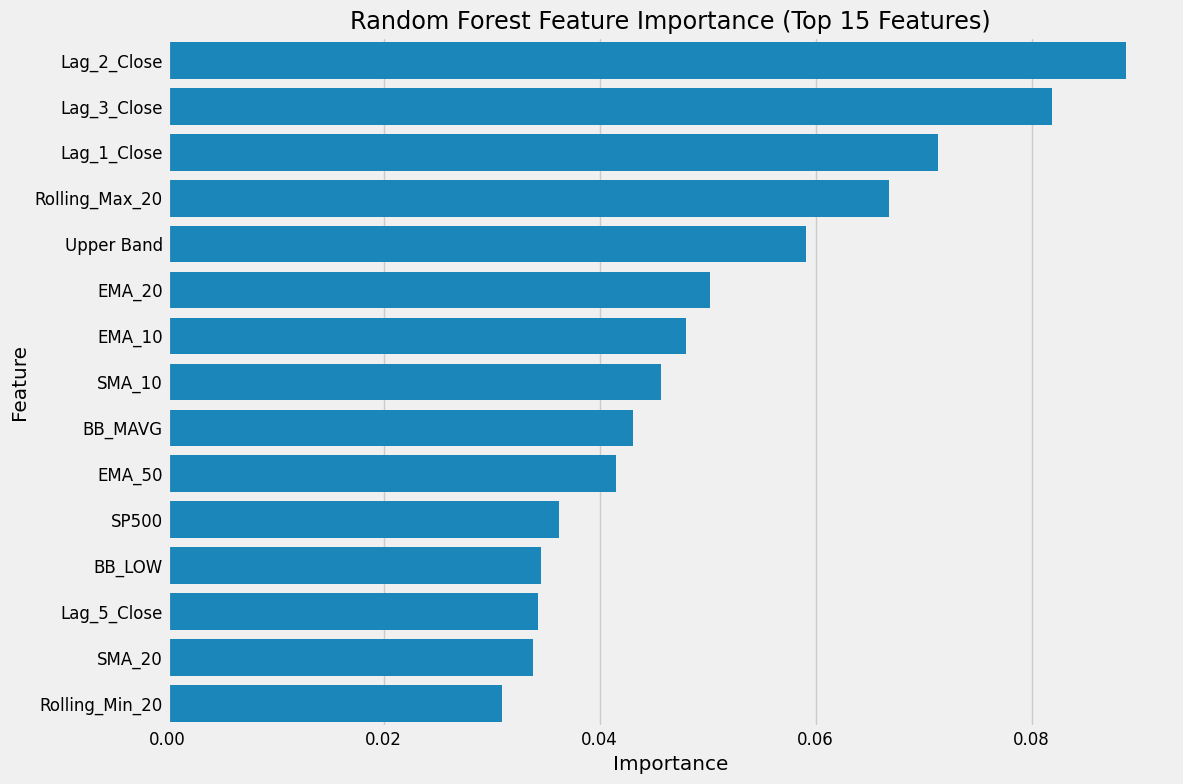

In [ ]:
print_header("RANDOM FOREST FEATURE IMPORTANCE")

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_features=5,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X, y)

y_pred_rf = rf_model.predict(X)

print("\nRandom Forest Performance:")
print("MAE :", mean_absolute_error(y, y_pred_rf))
print("MSE :", mean_squared_error(y, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y, y_pred_rf)))
print("R²  :", r2_score(y, y_pred_rf))

rf_importances = rf_model.feature_importances_
rf_feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_importances
})
rf_feature_importance = rf_feature_importance.sort_values('Importance', ascending=False)

print("\nTop 15 features by Random Forest importance:")
print(rf_feature_importance.head(15))

rf_feature_all = pd.DataFrame(
    [tree.feature_importances_ for tree in rf_model.estimators_],
    columns=X.columns
)

rf_feature_long = pd.melt(
    rf_feature_all.reset_index(),
    id_vars=['index'],
    var_name='feature name',
    value_name='feature importance'
)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=rf_feature_importance.head(15))
plt.title('Random Forest Feature Importance (Top 15 Features)')
plt.tight_layout()


In [ ]:
print_header("XGBOOST FEATURE IMPORTANCE")

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=20,
    learning_rate=0.05,
    max_depth=3,
    alpha=10,
    eta=0.1,
    subsample=0.7,
    colsample_bytree=0.8,
    reg_lambda=1,
    gamma=0
)

xgb_model.fit(X, y)

xgb_importances = xgb_model.feature_importances_
xgb_feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_importances
})
xgb_feature_importance = xgb_feature_importance.sort_values('Importance', ascending=False)

print("\nTop 15 features by XGBoost (manual params):")
print(xgb_feature_importance.head(15))

y_pred_xgb_manual = xgb_model.predict(X)

print("\nManual XGBoost Performance:")
print("MAE :", mean_absolute_error(y, y_pred_xgb_manual))
print("MSE :", mean_squared_error(y, y_pred_xgb_manual))
print("RMSE:", np.sqrt(mean_squared_error(y, y_pred_xgb_manual)))
print("R²  :", r2_score(y, y_pred_xgb_manual))

 XGBOOST FEATURE IMPORTANCE 

Top 15 features by XGBoost (manual params):
           Feature  Importance
33  Rolling_Max_20    0.415252
24     Lag_2_Close    0.280032
22     Lag_1_Close    0.113738
2           EMA_10    0.067822
16             OBV    0.046219
26     Lag_3_Close    0.027321
28     Lag_4_Close    0.021492
15          ATR_14    0.014335
34  Rolling_Min_20    0.006402
0           SMA_10    0.003254
54           SP500    0.002686
1           SMA_50    0.000986
7           RSI_14    0.000165
46       ADS_Index    0.000123
21      Log_Return    0.000057

Manual XGBoost Performance:
MAE : 0.32505579377344146
MSE : 0.18684094753195007
RMSE: 0.43225102374887453
R²  : 0.813010293751862


In [ ]:
print_header("XGBOOST HYPERPARAMETER TUNING")

param_grid = {
    "max_depth": [3, 5, 10],
    "n_estimators": [10, 50, 100],
    "learning_rate": [0.15, 0.3]
}

xgb_base = xgb.XGBRegressor(eval_metric='rmsle')
grid_search = GridSearchCV(xgb_base, param_grid, cv=5)
grid_search.fit(X, y)

print("The best hyperparameters are:", grid_search.best_params_)

xgb_tuned = xgb.XGBRegressor(
    learning_rate=grid_search.best_params_["learning_rate"],
    n_estimators=grid_search.best_params_["n_estimators"],
    max_depth=grid_search.best_params_["max_depth"],
    eval_metric='rmsle'
)

xgb_tuned.fit(X, y)

y_pred_xgb_tuned = xgb_tuned.predict(X)

print("\nTuned XGBoost Performance:")
print("MAE :", mean_absolute_error(y, y_pred_xgb_tuned))
print("MSE :", mean_squared_error(y, y_pred_xgb_tuned))
print("RMSE:", np.sqrt(mean_squared_error(y, y_pred_xgb_tuned)))
print("R²  :", r2_score(y, y_pred_xgb_tuned))

 XGBOOST HYPERPARAMETER TUNING 
The best hyperparameters are: {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 100}

Tuned XGBoost Performance:
MAE : 0.01131581804493831
MSE : 0.0002035033904614534
RMSE: 0.014265461452804582
R²  : 0.9997963345845461


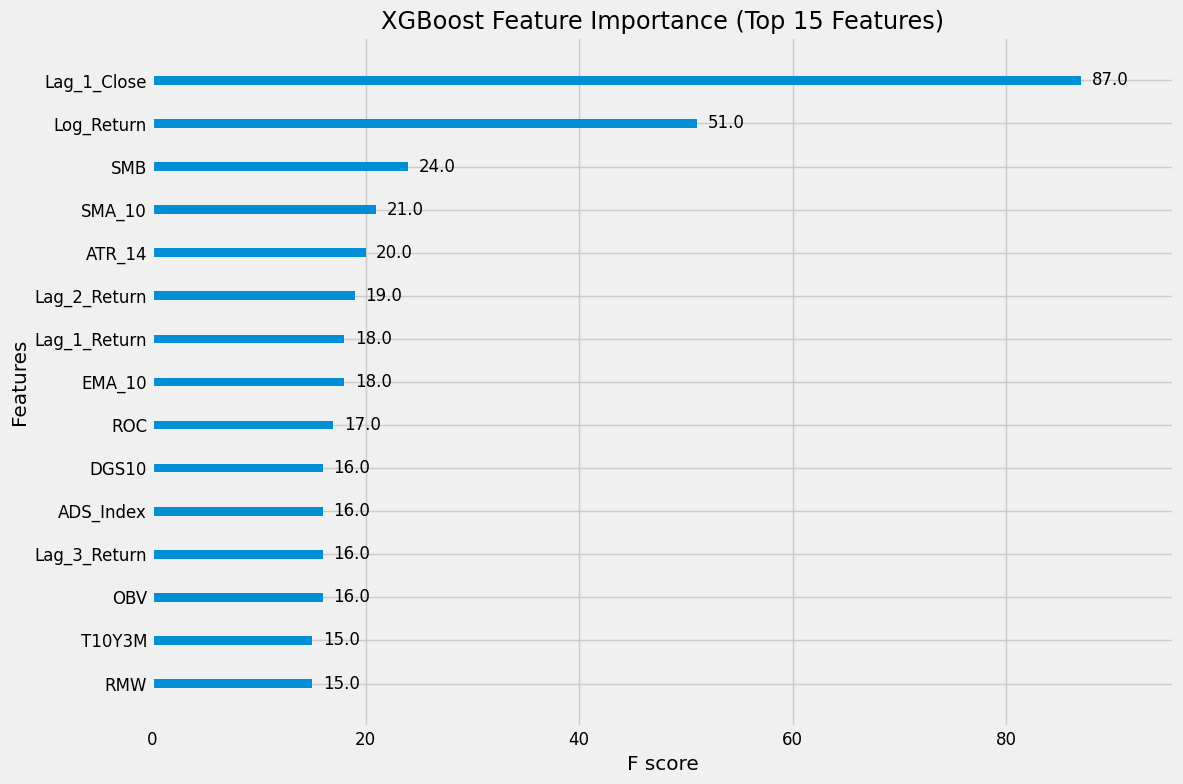

In [ ]:
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 12})

fig, ax = plt.subplots(figsize=(12, 8))
plot_importance(xgb_tuned, max_num_features=15, ax=ax, importance_type='weight')
plt.title("XGBoost Feature Importance (Top 15 Features)")
plt.tight_layout()

In [ ]:
print_header("FEATURE SELECTION COMPARISON")

rf_top_features = rf_feature_importance['Feature'].head(15).tolist()
xgb_top_features = xgb_feature_importance['Feature'].head(15).tolist()

common_features = set(rf_top_features).intersection(set(xgb_top_features))

print("Features selected by both Random Forest and XGBoost:")
for feature in common_features:
    print(f"- {feature}")

correlation = {}
for col in feature_cols:
    correlation[col] = abs(data[col].corr(data[target]))

correlation_sorted = sorted(correlation.items(), key=lambda x: x[1], reverse=True)
corr_features = [x[0] for x in correlation_sorted[:15]]

for i, (feature, corr) in enumerate(correlation_sorted[:15], 1):
    print(f"{i}. {feature}: {corr:.4f}")

tree_corr_overlap = set(list(common_features)).intersection(set(corr_features))

print(f"\nFeatures selected by both tree methods AND correlation ({len(tree_corr_overlap)}):")
for feature in tree_corr_overlap:
    print(f"- {feature}")


 FEATURE SELECTION COMPARISON 
Features selected by both Random Forest and XGBoost:
- SMA_50
- OBV
- SP500
- Lag_4_Close
- Rolling_Max_20
- Rolling_Min_20
- EMA_10
- Lag_2_Close
- Lag_1_Close
- SMA_10
1. Lag_1_Close: 0.9981
2. EMA_10: 0.9968
3. Lag_2_Close: 0.9964
4. SMA_10: 0.9955
5. Lag_3_Close: 0.9948
6. Lag_4_Close: 0.9932
7. EMA_20: 0.9931
8. Lag_5_Close: 0.9917
9. SMA_20: 0.9906
10. BB_MAVG: 0.9906
11. Rolling_Min_20: 0.9900
12. Rolling_Max_20: 0.9882
13. BB_LOW: 0.9865
14. Lower Band: 0.9862
15. BB_HIGH: 0.9850

Features selected by both tree methods AND correlation (7):
- Lag_4_Close
- Rolling_Max_20
- Rolling_Min_20
- EMA_10
- Lag_2_Close
- Lag_1_Close
- SMA_10


In [ ]:
print_header("KEY FINDINGS AND RECOMMENDATIONS")

print("1. The top features identified by Random Forest are:")
for i, feature in enumerate(rf_top_features[:10], 1):
    importance = rf_feature_importance.loc[rf_feature_importance['Feature'] == feature, 'Importance'].values[0]
    print(f"   {i}. {feature} (Importance: {importance:.4f})")

print("\n2. The top features identified by XGBoost are:")
for i, feature in enumerate(xgb_top_features[:10], 1):
    importance = xgb_feature_importance.loc[xgb_feature_importance['Feature'] == feature, 'Importance'].values[0]
    print(f"   {i}. {feature} (Importance: {importance:.4f})")

print("\n3. The most consistently important features across methods are:")
for feature in common_features:
    rf_imp = rf_feature_importance.loc[rf_feature_importance['Feature'] == feature, 'Importance'].values[0]
    xgb_imp = xgb_feature_importance.loc[xgb_feature_importance['Feature'] == feature, 'Importance'].values[0]
    avg_imp = (rf_imp + xgb_imp) / 2
    print(f"   - {feature} (Avg. Importance: {avg_imp:.4f})")



print("\nRECOMMENDED FEATURES FOR META STOCK PREDICTION:")
if common_features:
    print("Based on consistent selection across multiple tree-based models:")
    for feature in common_features:
        print(f"- {feature}")
else:
    print("Based on Random Forest importance:")
    for feature in rf_top_features[:10]:
        print(f"- {feature}")

 KEY FINDINGS AND RECOMMENDATIONS 
1. The top features identified by Random Forest are:
   1. Lag_1_Close (Importance: 0.0667)
   2. BB_HIGH (Importance: 0.0658)
   3. Rolling_Max_20 (Importance: 0.0647)
   4. Lag_4_Close (Importance: 0.0608)
   5. Lag_2_Close (Importance: 0.0571)
   6. SMA_10 (Importance: 0.0521)
   7. Lag_5_Close (Importance: 0.0510)
   8. BB_LOW (Importance: 0.0507)
   9. OBV (Importance: 0.0478)
   10. Rolling_Min_20 (Importance: 0.0459)

2. The top features identified by XGBoost are:
   1. Rolling_Max_20 (Importance: 0.4153)
   2. Lag_2_Close (Importance: 0.2800)
   3. Lag_1_Close (Importance: 0.1137)
   4. EMA_10 (Importance: 0.0678)
   5. OBV (Importance: 0.0462)
   6. Lag_3_Close (Importance: 0.0273)
   7. Lag_4_Close (Importance: 0.0215)
   8. ATR_14 (Importance: 0.0143)
   9. Rolling_Min_20 (Importance: 0.0064)
   10. SMA_10 (Importance: 0.0033)

3. The most consistently important features across methods are:
   - SMA_50 (Avg. Importance: 0.0196)
   - OBV (Av